# Example Notebook

Welcome to the example notebook for the Home Credit Kaggle competition. The goal of this competition is to determine how likely a customer is going to default on an issued loan. The main difference between the [first](https://www.kaggle.com/c/home-credit-default-risk) and this competition is that now your submission will be scored with a custom metric that will take into account how well the model performs in future. A decline in performance will be penalized. The goal is to create a model that is stable and performs well in the future.

In this notebook you will see how to:
* Load the data
* Join tables with Polars - a DataFrame library implemented in Rust language, designed to be blazingy fast and memory efficient.  
* Create simple aggregation features
* Train a LightGBM model
* Create a submission table

## Load the data

In [1]:
!pip install polars
!pip install pyarrow
!pip install CatBoost
!pip install phik
!pip install seaborn

In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import polars as pl
import seaborn as sns

from catboost import CatBoostClassifier, Pool

from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score 

dataPath = "/Users/vs/Programming/Data Science/Kaggle/1. home credit 2024/"
RANDOM_STATE = 40324

In [3]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [4]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [5]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

## Feature engineering

In this part, we can see a simple example of joining tables via `case_id`. Here the loading and joining is done with polars library. Polars library is blazingly fast and has much smaller memory footprint than pandas. 

In [6]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [7]:
del train_person_1
del train_credit_bureau_b_2
del train_basetable
del train_static
del train_static_cb
del train_person_1_feats_1
del train_person_1_feats_2
del train_credit_bureau_b_2_feats

In [8]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [9]:
del test_person_1
del test_credit_bureau_b_2
del test_basetable
del test_static
del test_static_cb
del test_person_1_feats_1
del test_person_1_feats_2
del test_credit_bureau_b_2_feats

In [51]:
case_ids = data["case_id"].unique().shuffle(seed=RANDOM_STATE)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=RANDOM_STATE)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=RANDOM_STATE)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [31]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


## Column data analysis

In [12]:
feature_definitions = pd.read_csv(dataPath + 'feature_definitions.csv')
feature_definitions_df = pd.DataFrame(feature_definitions)
X_train_df = pd.DataFrame(X_train)

column_description = {}

for variable, description in zip(feature_definitions_df['Variable'], feature_definitions_df['Description']):
    if variable in X_train_df.columns:
        column_description[variable] = description

print(column_description)

{'amtinstpaidbefduel24m_4187115A': 'Number of instalments paid before due date in the last 24 months.', 'annuity_780A': 'Monthly annuity amount.', 'annuitynextmonth_57A': "Next month's amount of annuity.", 'avginstallast24m_3658937A': 'Average instalments paid by the client over the past 24 months.', 'avglnamtstart24m_4525187A': 'Average loan amount in the last 24 months.', 'avgoutstandbalancel6m_4187114A': 'Average outstanding balance of applicant for the last 6 months.', 'avgpmtlast12m_4525200A': 'Average of payments made by the client in the last 12 months.', 'credamount_770A': 'Loan amount or credit card limit.', 'currdebt_22A': 'Current debt amount of the client.', 'currdebtcredtyperange_828A': 'Current amount of debt of the applicant.', 'description_5085714M': 'Categorization of clients by credit bureau.', 'disbursedcredamount_1113A': 'Disbursed credit amount after consolidation.', 'downpmt_116A': 'Amount of downpayment.', 'education_1103M': 'Level of education of the client prov

In [13]:
def get_boxplot(column):
    
    data = {
        'Х_train': [],
        'Х_valid': [],
        'Х_test': []
    }


    an_df = pd.DataFrame(data)

    an_df['Х_train'] = X_train[column]
    an_df['Х_valid'] = X_valid[column]
    an_df['Х_test'] = X_test[column]

    plt.figure(figsize=(15, 5))
    sns.boxplot(data=an_df, orient='h', palette='Set1')
    plt.title(column_description[column])
    plt.ylabel(column)
    plt.show()
    print(an_df.describe())

interval columns not set, guessing: ['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcredamount_781A', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcredamount_222A', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallast1m_4525188A', 'pmtaverage_3A', 'pmtaverage_4527227A', 'pmtaverage_4955615A', 'pmtssum_45A']


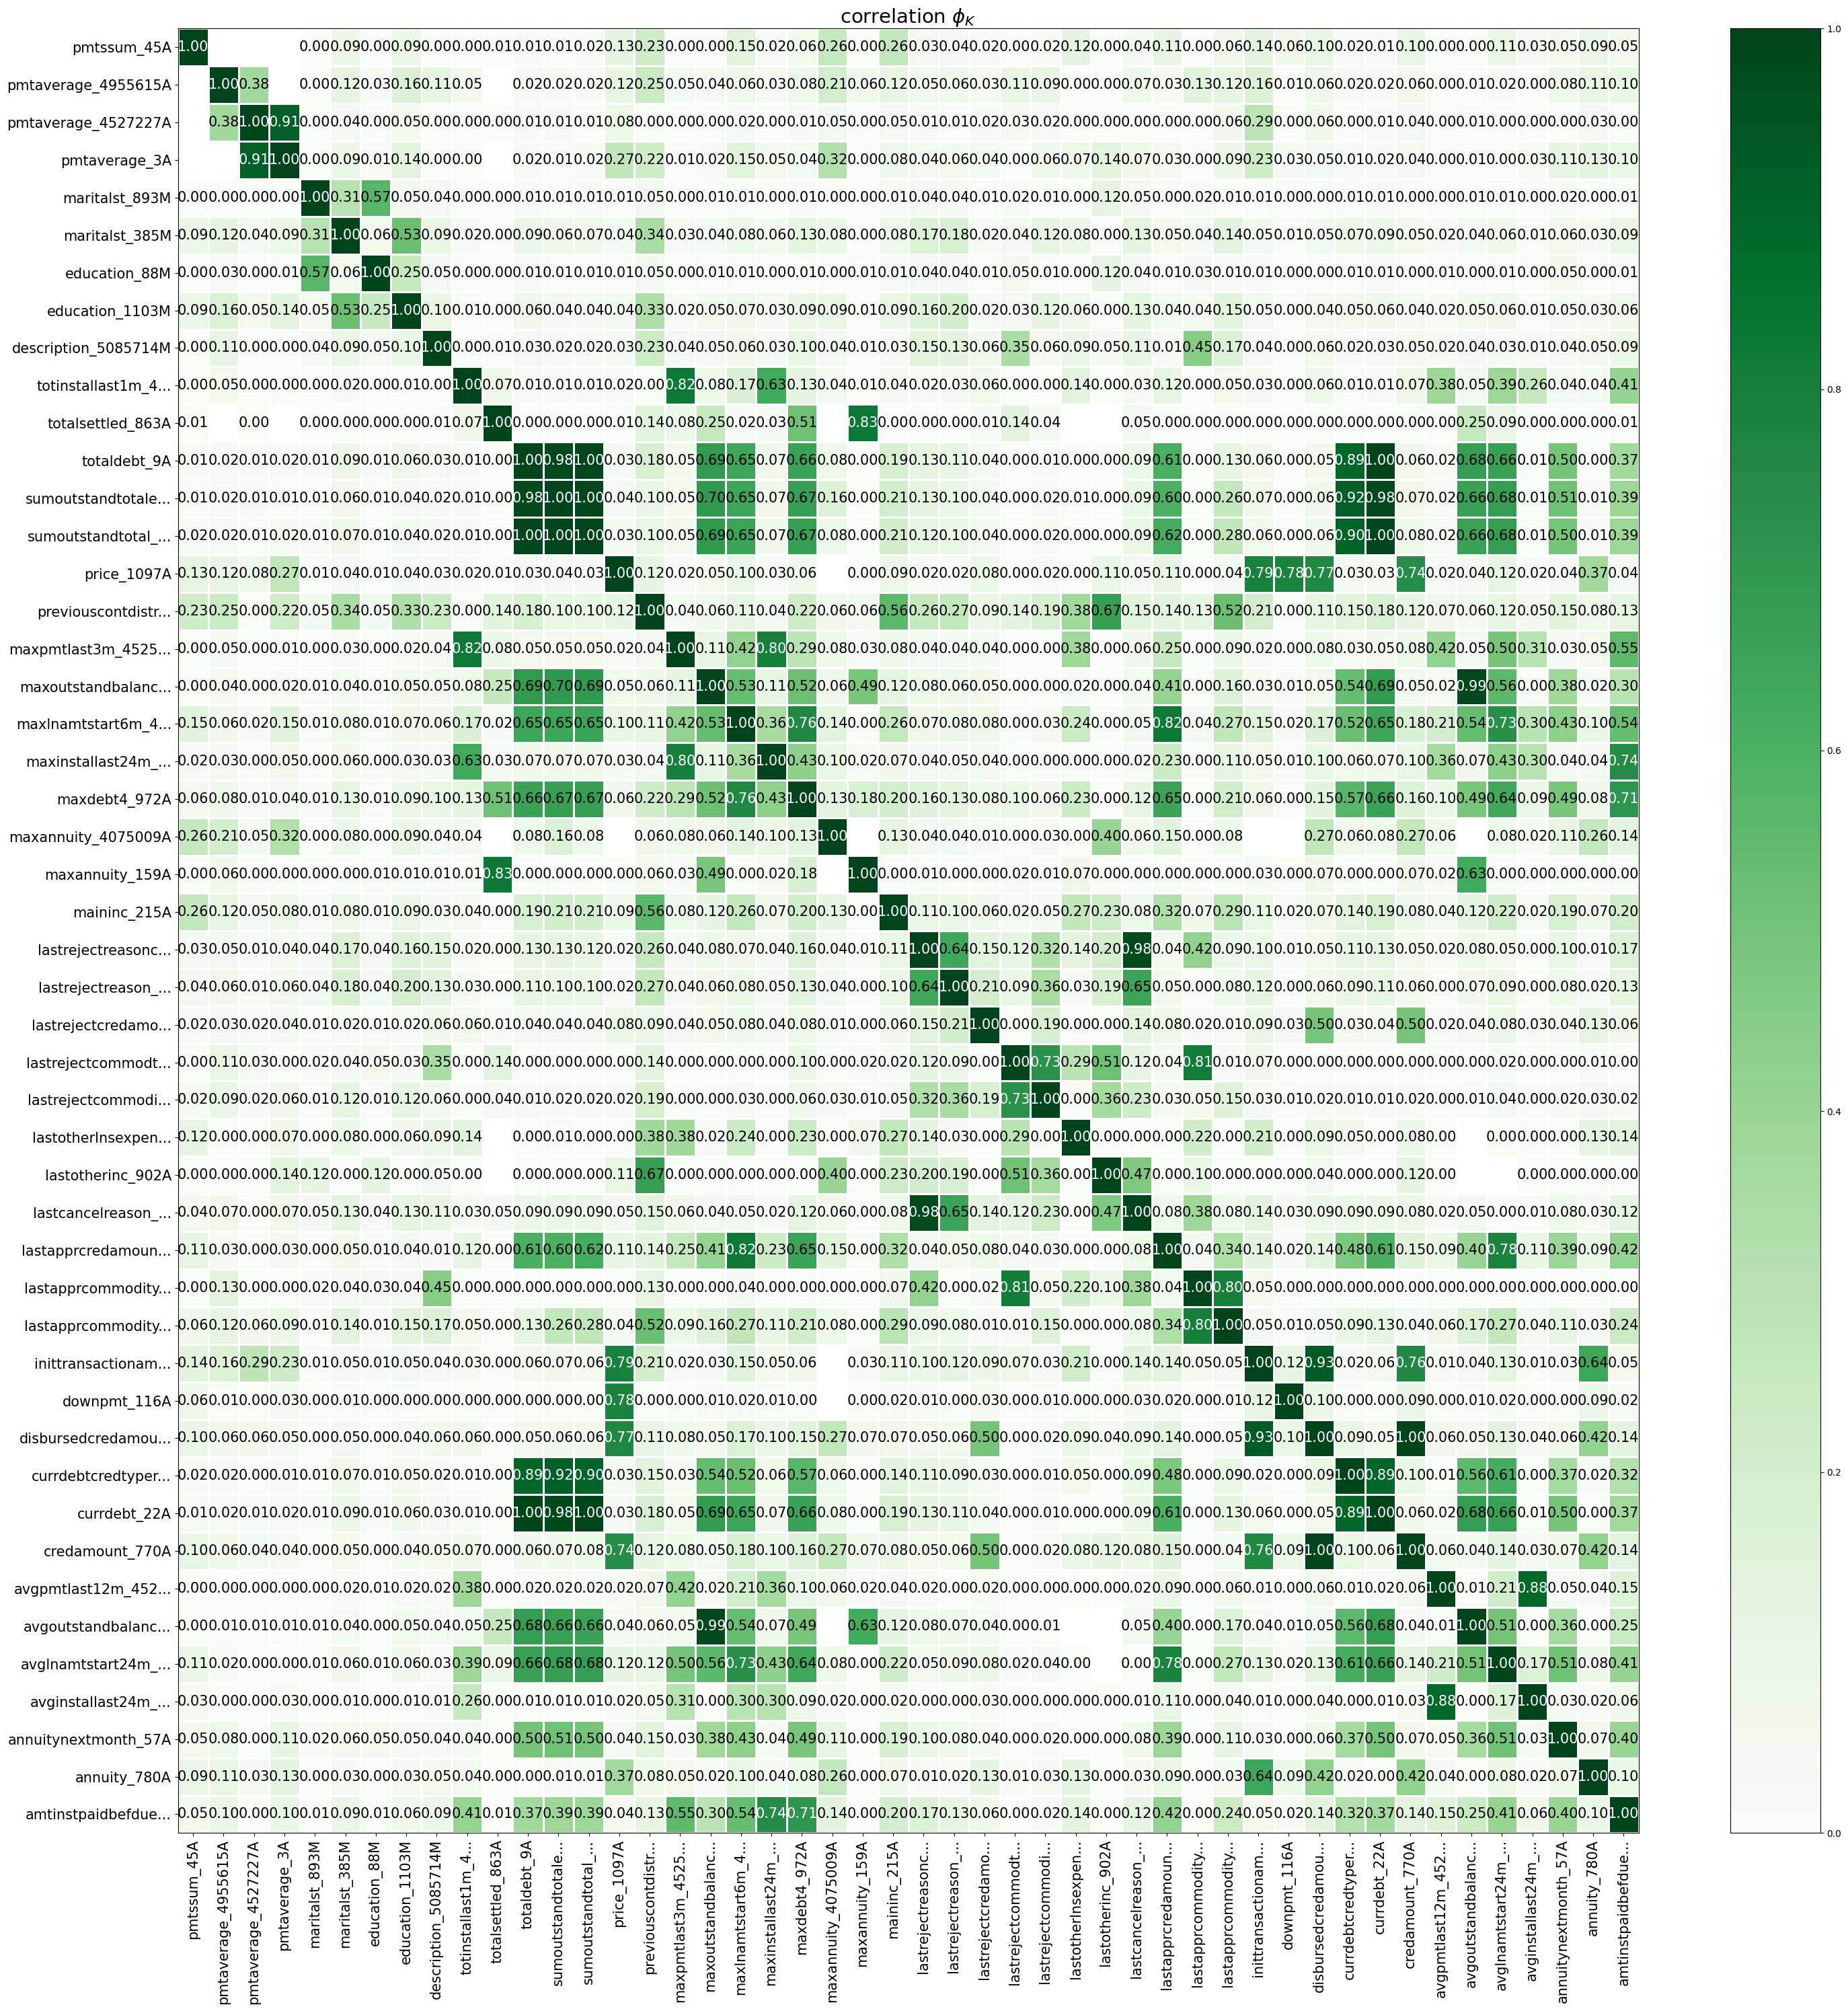

In [15]:
phik_overview = X_train.phik_matrix() # type: ignore

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(30, 30))
plt.tight_layout()

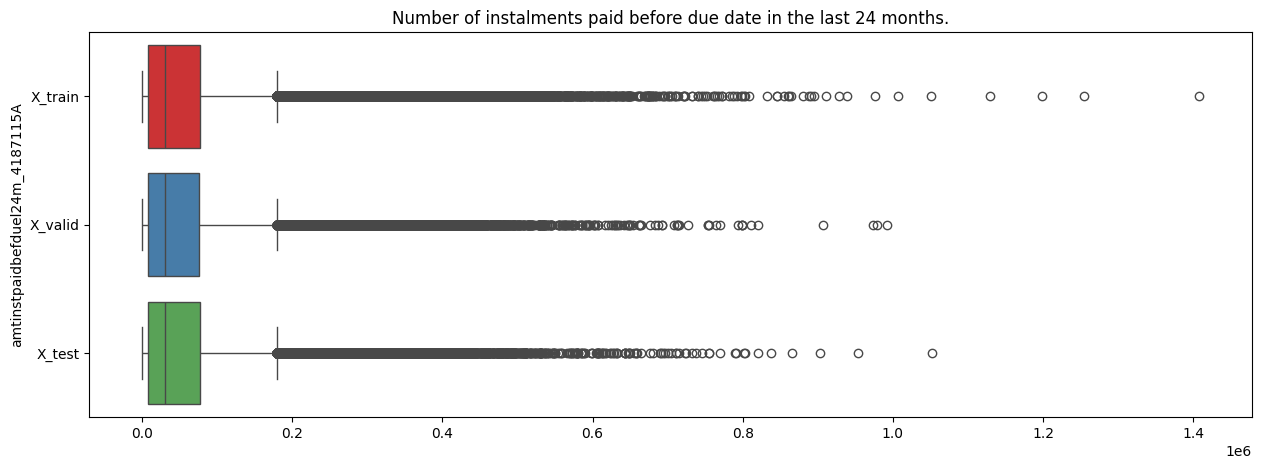

            Х_train        Х_valid        Х_test
count  5.792920e+05  193279.000000  1.929640e+05
mean   5.591278e+04   56024.985113  5.602831e+04
std    7.154372e+04   71765.285899  7.167425e+04
min    0.000000e+00       0.000000  0.000000e+00
25%    7.419600e+03    7275.300000  7.542725e+03
50%    2.973411e+04   29735.800000  2.984950e+04
75%    7.631142e+04   76254.692000  7.632360e+04
max    1.408010e+06  992476.500000  1.052333e+06


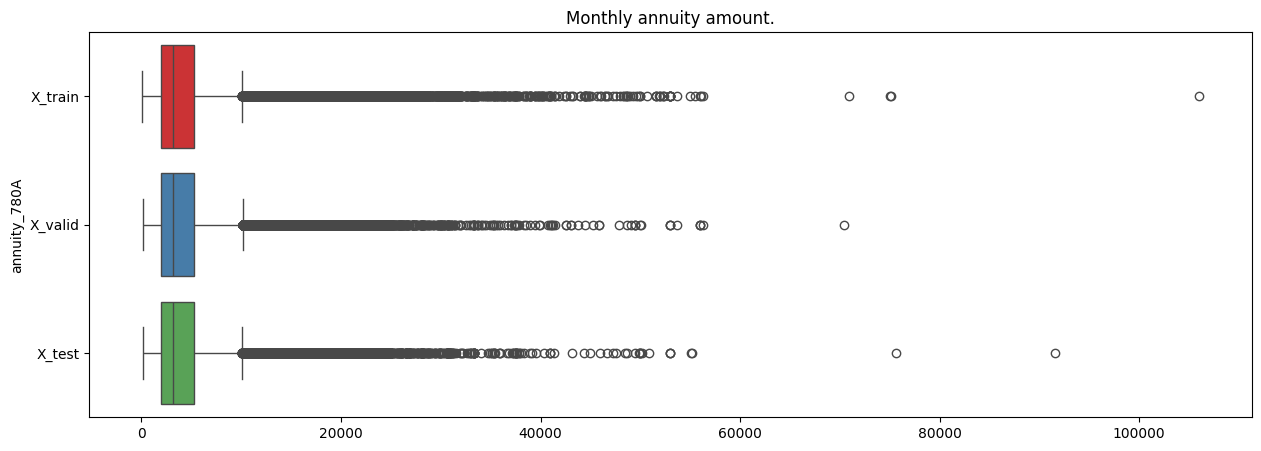

             Х_train        Х_valid         Х_test
count  915995.000000  305332.000000  305332.000000
mean     4037.053979    4044.596271    4040.278146
std      3003.026916    3015.874775    3008.064116
min        80.800000     149.400010     145.800000
25%      1967.200100    1967.600000    1969.800000
50%      3150.400100    3154.400100    3152.200000
75%      5230.800300    5235.200000    5229.800300
max    106007.000000   70459.400000   91601.400000


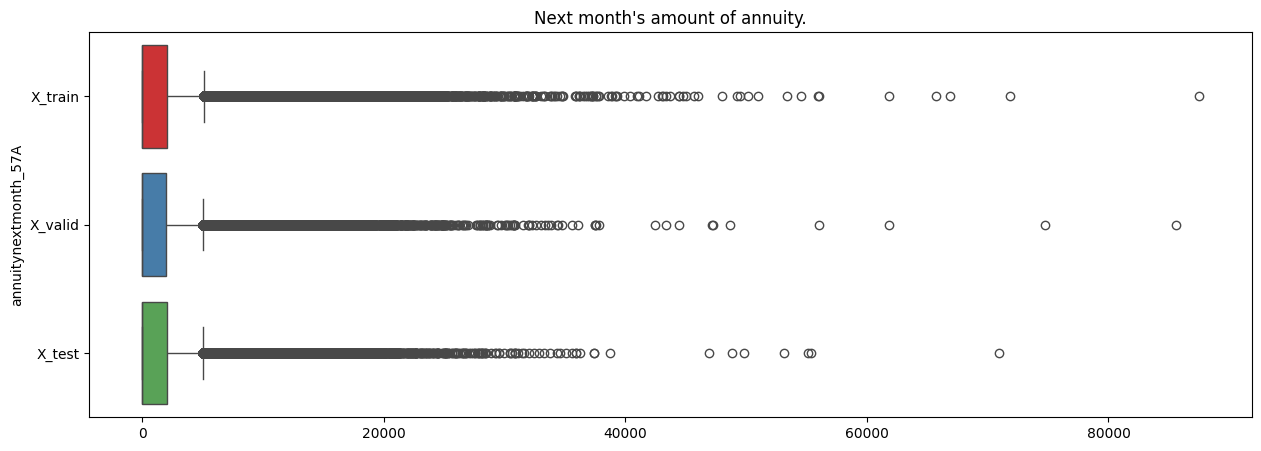

             Х_train        Х_valid         Х_test
count  915993.000000  305330.000000  305332.000000
mean     1438.215890    1432.362479    1431.864927
std      2808.628884    2812.050825    2797.146676
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%      2041.200100    2002.800000    2015.400000
max     87500.000000   85620.805000   70924.200000


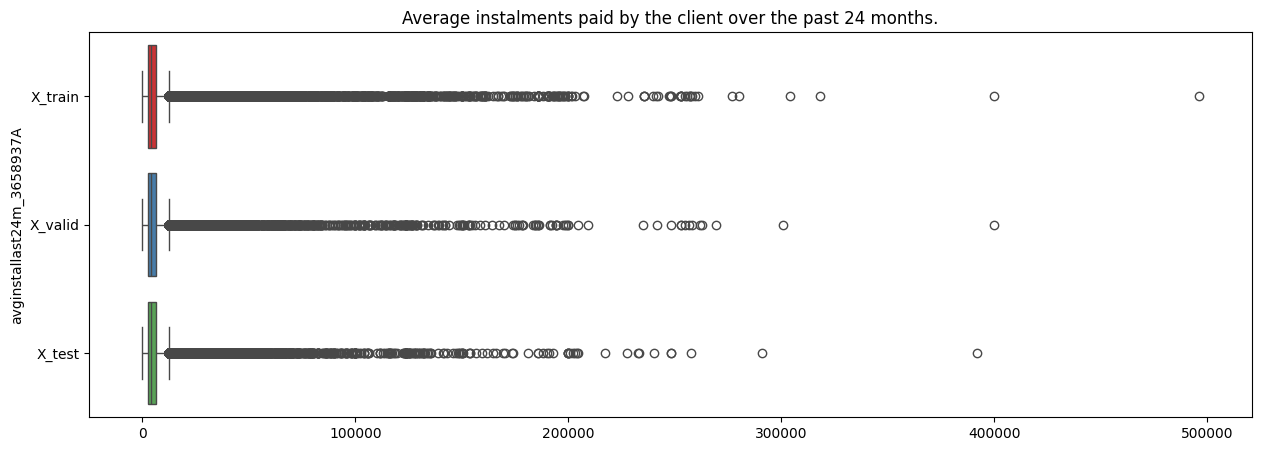

             Х_train        Х_valid         Х_test
count  541370.000000  180113.000000  180301.000000
mean     5393.635247    5428.024747    5399.055858
std      6523.567317    6661.222105    6423.822505
min         0.000000       0.000000       0.200000
25%      2524.400100    2536.400100    2533.400100
50%      4065.400100    4077.800000    4067.400100
75%      6545.600000    6571.400000    6550.400000
max    496148.800000  400000.000000  391795.220000


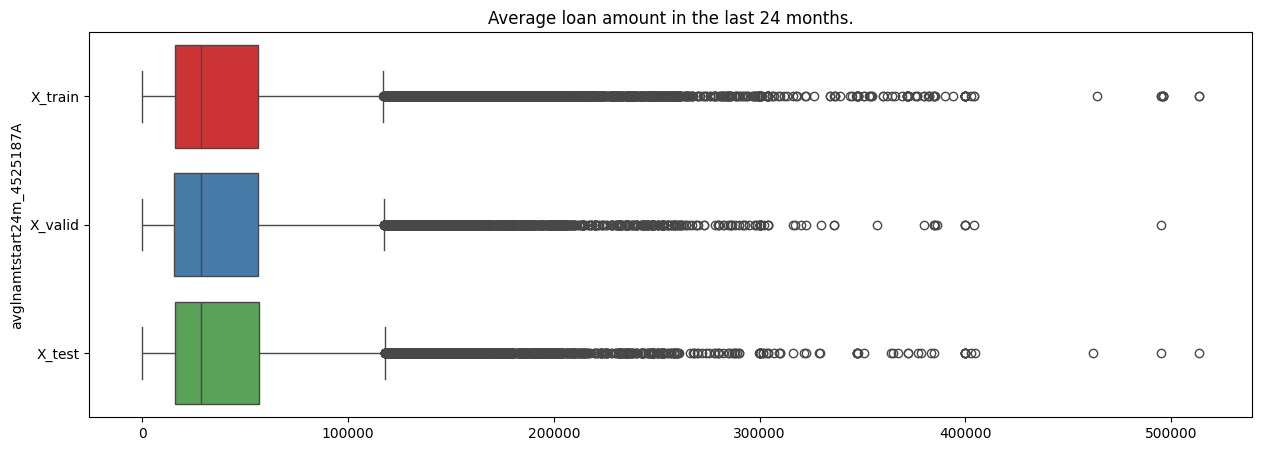

             Х_train        Х_valid         Х_test
count   97623.000000   32339.000000   32547.000000
mean    44658.488032   44760.755595   44851.857409
std     44769.567665   44948.881427   44967.539668
min         0.000000       0.000000       0.000000
25%     15718.601000   15480.700000   15743.300500
50%     28419.400000   28419.400000   28548.000000
75%     56309.101000   56225.800000   56557.000000
max    513520.000000  495251.220000  513520.000000


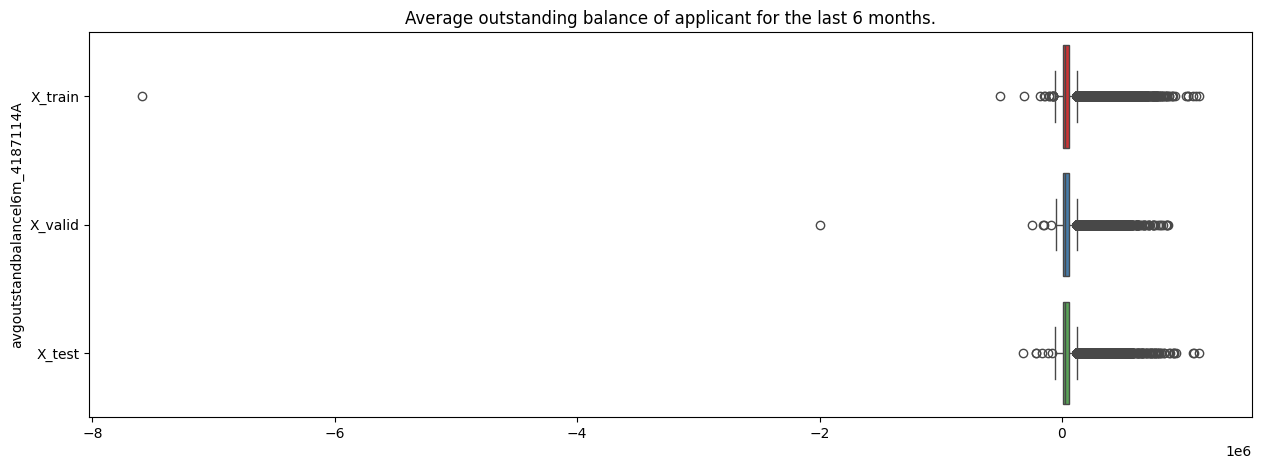

            Х_train       Х_valid        Х_test
count  4.115450e+05  1.367250e+05  1.372080e+05
mean   4.595938e+04  4.607645e+04  4.596986e+04
std    6.435128e+04  6.348708e+04  6.341993e+04
min   -7.588198e+06 -2.000000e+06 -3.200000e+05
25%    8.696532e+03  8.754647e+03  8.713476e+03
50%    2.272751e+04  2.275831e+04  2.284265e+04
75%    5.539809e+04  5.566667e+04  5.532658e+04
max    1.128721e+06  8.724143e+05  1.131136e+06


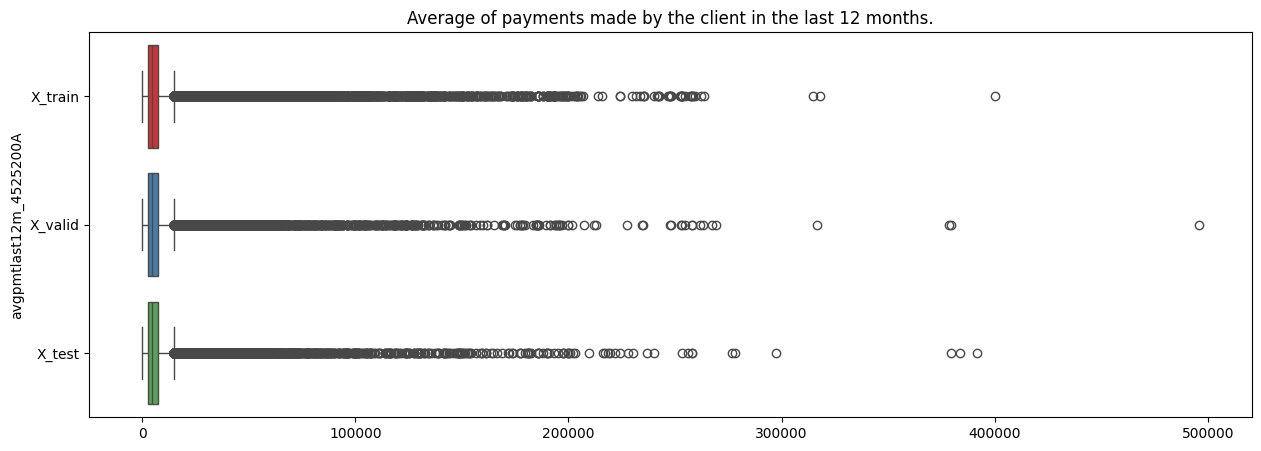

             Х_train        Х_valid         Х_test
count  300125.000000   99467.000000  100080.000000
mean     6389.822316    6456.946362    6391.763959
std      9095.306652    9587.866294    9357.440477
min         0.000000       0.000000       0.000000
25%      2588.400100    2594.000000    2591.400100
50%      4419.000000    4425.800300    4406.000000
75%      7512.600000    7577.300000    7500.850225
max    400000.000000  495910.400000  391795.220000


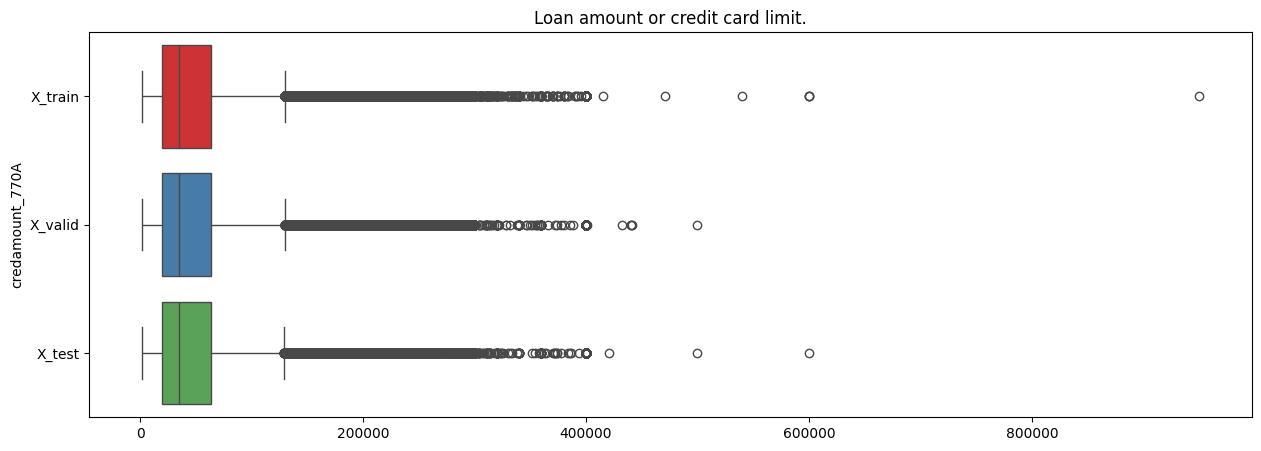

             Х_train        Х_valid         Х_test
count  915995.000000  305332.000000  305332.000000
mean    49879.950127   49902.527783   49808.421038
std     44180.420010   44350.001774   44026.702456
min      2000.000000    2000.000000    2000.000000
25%     19998.000000   19980.000000   19996.000000
50%     35200.000000   35100.000000   35272.201000
75%     63994.000000   63998.000000   63742.350000
max    950000.000000  500000.000000  600000.000000


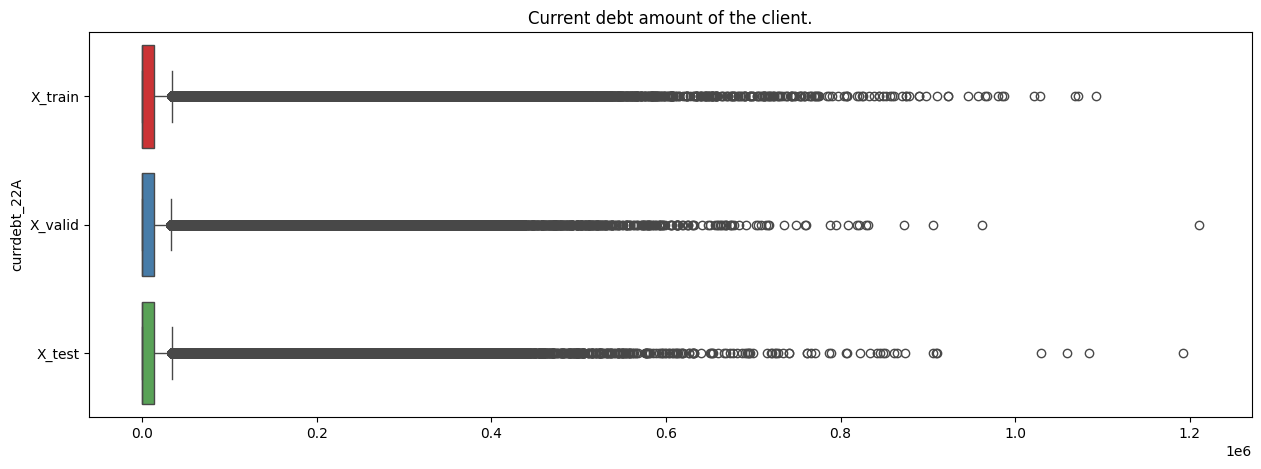

            Х_train       Х_valid        Х_test
count  9.159930e+05  3.053300e+05  3.053320e+05
mean   1.970342e+04  1.963414e+04  1.966772e+04
std    5.083716e+04  5.075666e+04  5.090829e+04
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00
75%    1.355800e+04  1.326770e+04  1.352520e+04
max    1.092393e+06  1.210629e+06  1.192101e+06


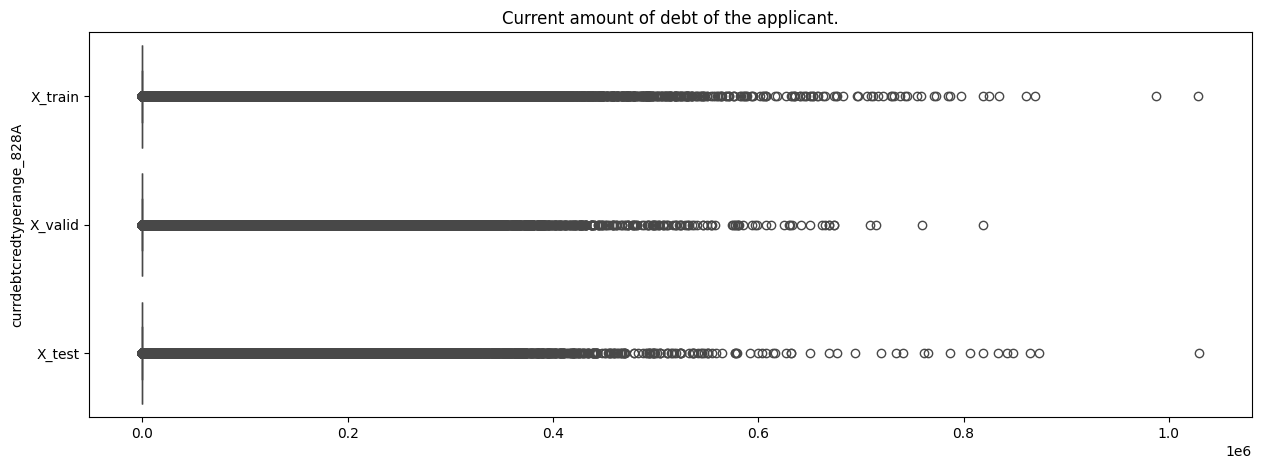

            Х_train        Х_valid        Х_test
count  9.159930e+05  305330.000000  3.053320e+05
mean   1.100286e+04   11028.545308  1.094468e+04
std    3.676071e+04   37014.784337  3.665377e+04
min    0.000000e+00       0.000000  0.000000e+00
25%    0.000000e+00       0.000000  0.000000e+00
50%    0.000000e+00       0.000000  0.000000e+00
75%    0.000000e+00       0.000000  0.000000e+00
max    1.028338e+06  818581.000000  1.029393e+06


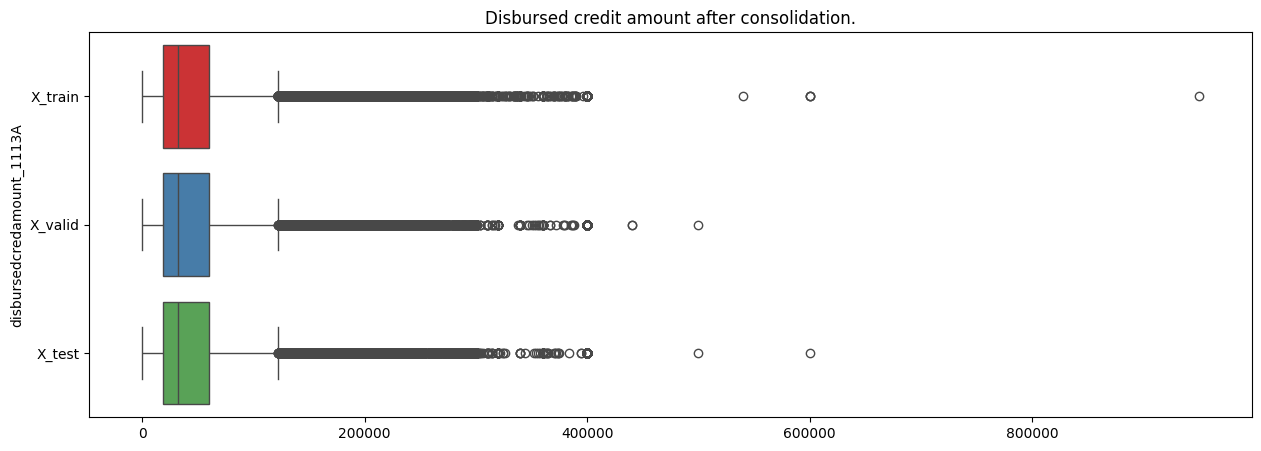

             Х_train        Х_valid         Х_test
count  915995.000000  305332.000000  305332.000000
mean    46080.007672   46097.568704   46036.170001
std     42496.390926   42665.407306   42372.238595
min         0.000000       0.000000       0.000000
25%     18440.000000   18380.000000   18400.000000
50%     31940.000000   31934.900000   31956.000000
75%     60000.000000   60000.000000   60000.000000
max    950000.000000  500000.000000  600000.000000


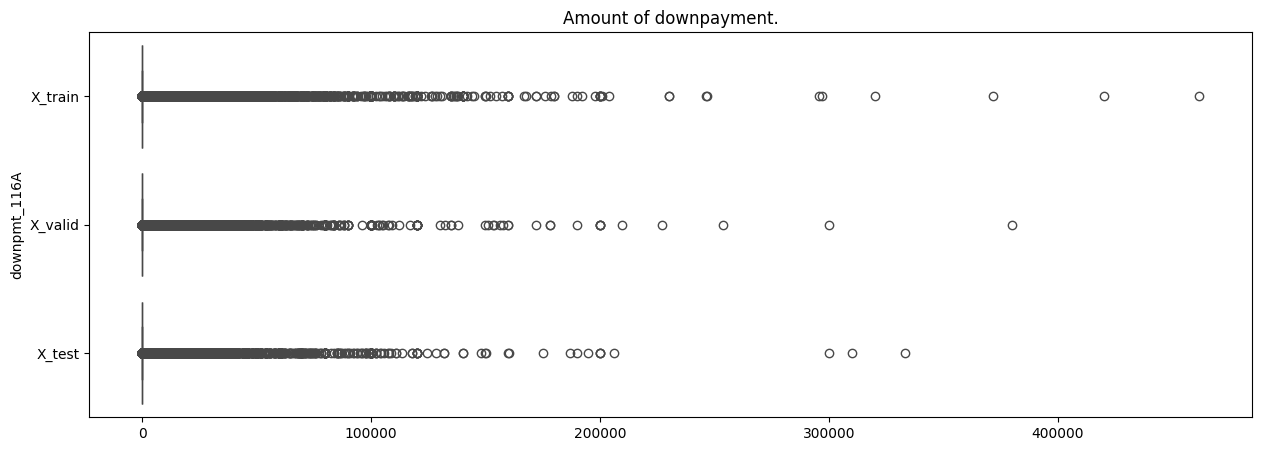

             Х_train        Х_valid         Х_test
count  915995.000000  305332.000000  305332.000000
mean      553.427934     554.471430     547.149892
std      4102.714773    4131.743057    4063.960707
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%         0.000000       0.000000       0.000000
max    461867.400000  380000.000000  333442.400000


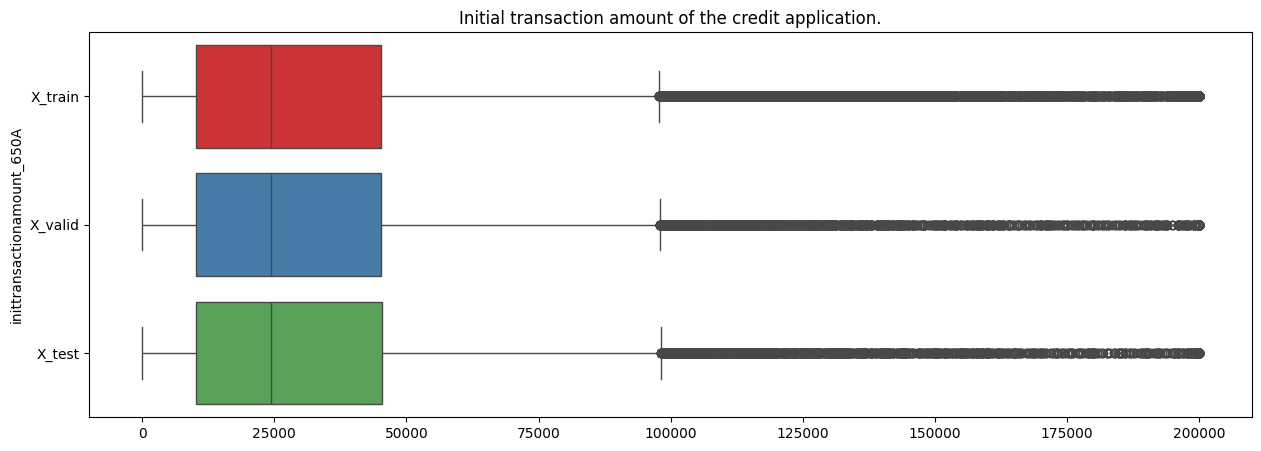

             Х_train        Х_valid         Х_test
count  115562.000000   38438.000000   38302.000000
mean    32534.837942   32550.781853   32646.499391
std     33093.096692   33226.406557   33205.063953
min         0.000000       0.000000       0.000000
25%     10138.000000   10160.000000   10198.000000
50%     24376.000000   24317.000000   24398.000000
75%     45194.000000   45255.500000   45374.551500
max    200000.000000  200000.000000  200000.000000


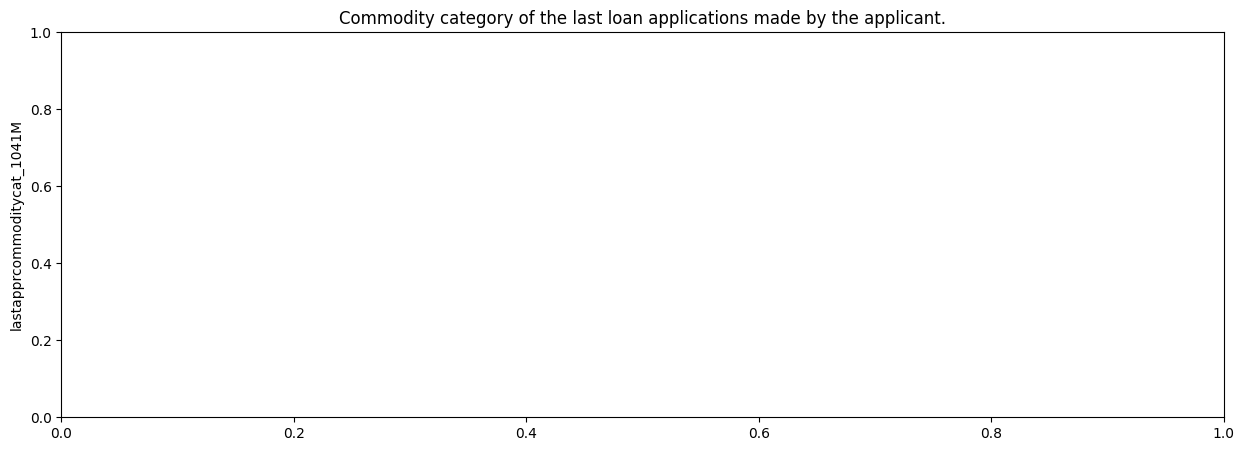

         Х_train   Х_valid    Х_test
count     915995    305332    305332
unique        44        43        40
top     a55475b1  a55475b1  a55475b1
freq      511392    170484    170370


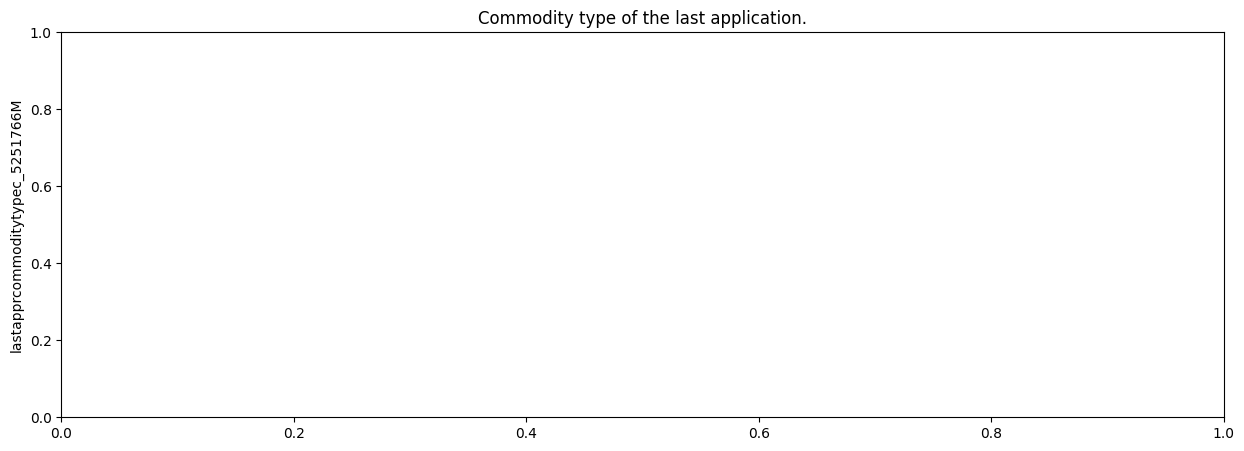

         Х_train   Х_valid    Х_test
count     915995    305332    305332
unique       194       141       145
top     a55475b1  a55475b1  a55475b1
freq      902355    300630    300672


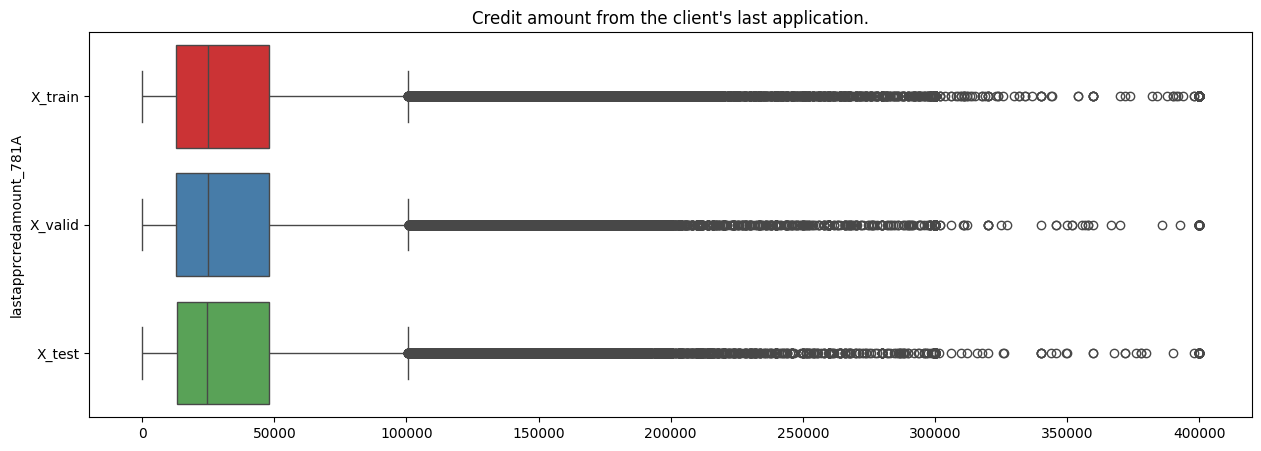

             Х_train        Х_valid         Х_test
count  650910.000000  216878.000000  216830.000000
mean    36915.728759   36976.206488   36728.286192
std     36999.737902   37235.168363   36787.832477
min         0.000000       0.000000       0.000000
25%     12886.000000   12820.000000   12980.000000
50%     24782.500000   24796.000000   24681.000000
75%     48000.000000   48000.000000   47978.000000
max    400000.000000  400000.000000  400000.000000


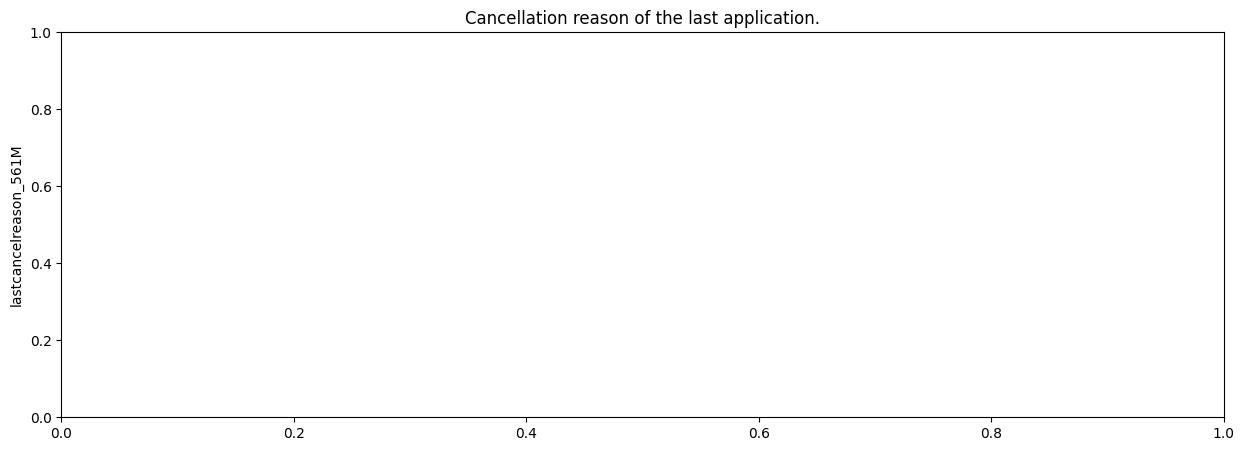

         Х_train   Х_valid    Х_test
count     915995    305332    305332
unique        70        64        64
top     a55475b1  a55475b1  a55475b1
freq      644650    214851    214552


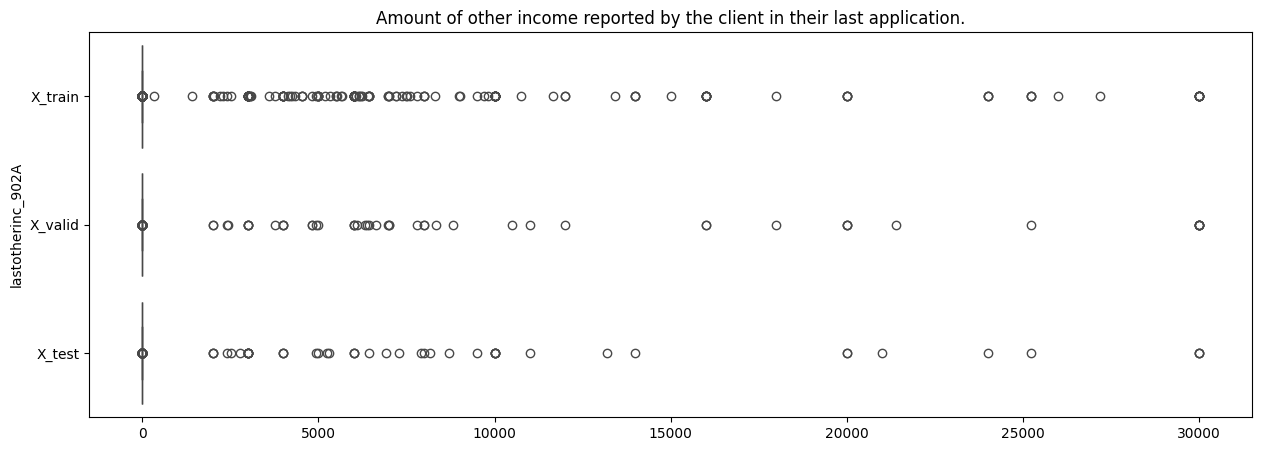

            Х_train       Х_valid       Х_test
count   1837.000000    621.000000    598.00000
mean     770.732155    866.586313    730.11388
std     3358.212925   3903.391770   3345.82709
min        0.000000      0.000000      0.00000
25%        0.200000      0.200000      0.20000
50%        0.200000      0.200000      0.20000
75%        0.200000      0.200000      0.20000
max    30000.000000  30000.000000  30000.00000


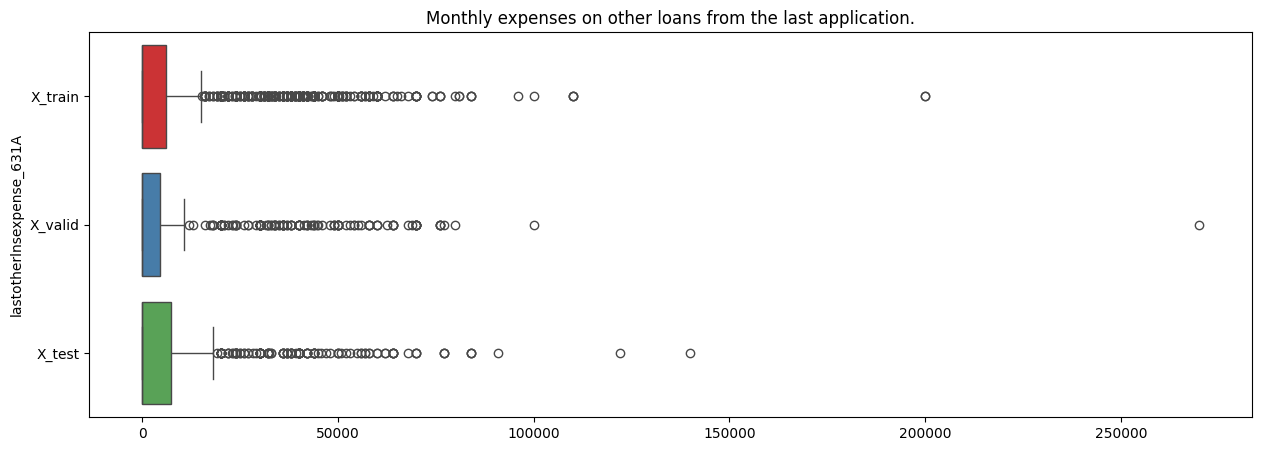

             Х_train        Х_valid         Х_test
count    1826.000000     632.000000     600.000000
mean     9142.246769    9773.117089    9624.110000
std     18638.197849   21273.134783   19374.293881
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%      6000.000000    4600.000000    7400.000000
max    200000.000000  270000.000000  140000.000000


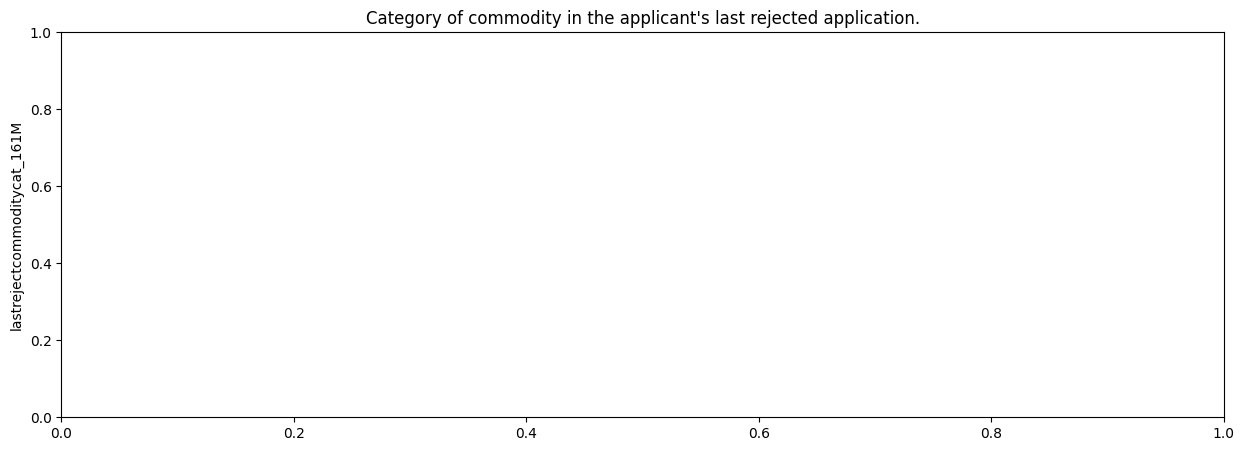

         Х_train   Х_valid    Х_test
count     915995    305332    305332
unique        43        38        40
top     a55475b1  a55475b1  a55475b1
freq      730009    243211    242765


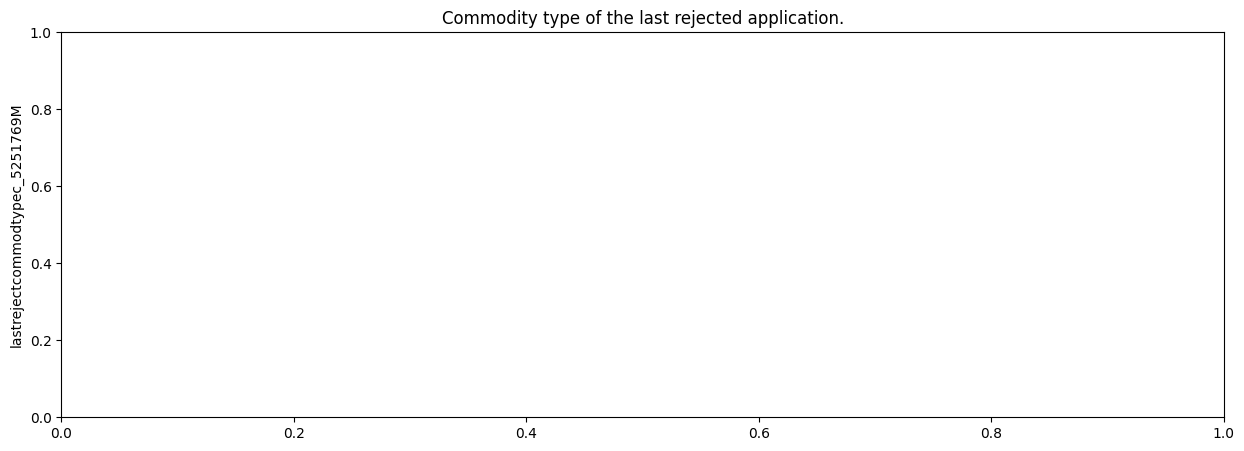

         Х_train   Х_valid    Х_test
count     915995    305332    305332
unique       164       126       119
top     a55475b1  a55475b1  a55475b1
freq      908389    302777    302681


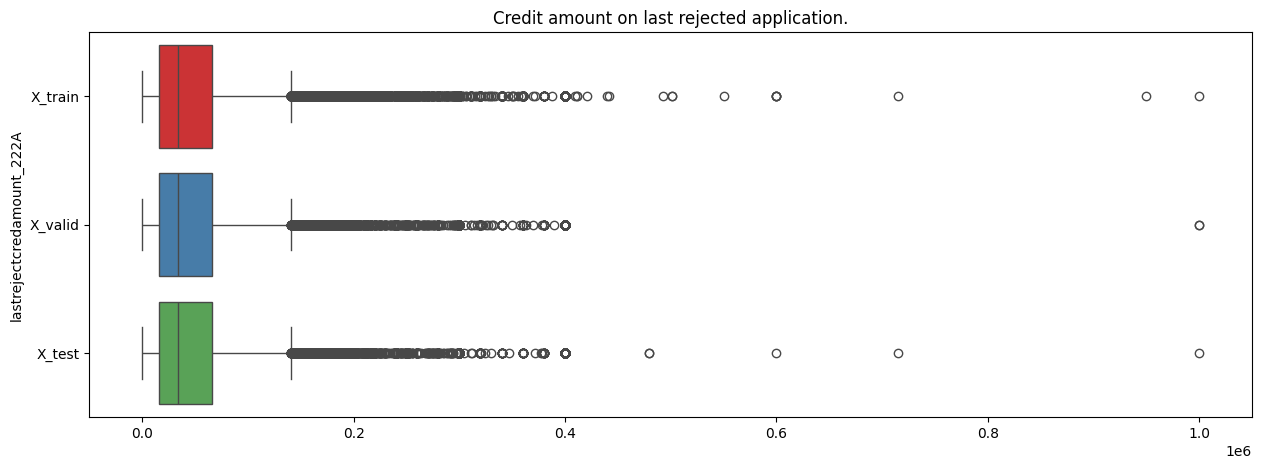

              Х_train         Х_valid          Х_test
count   454384.000000   151341.000000   151888.000000
mean     51071.385443    51073.218103    50958.148899
std      53211.425848    53383.511414    52842.101731
min          0.000000        0.000000        0.000000
25%      16200.000000    16116.000000    16194.000000
50%      34000.000000    33858.000000    33994.000000
75%      66000.000000    66000.000000    66000.000000
max    1000000.000000  1000000.000000  1000000.000000


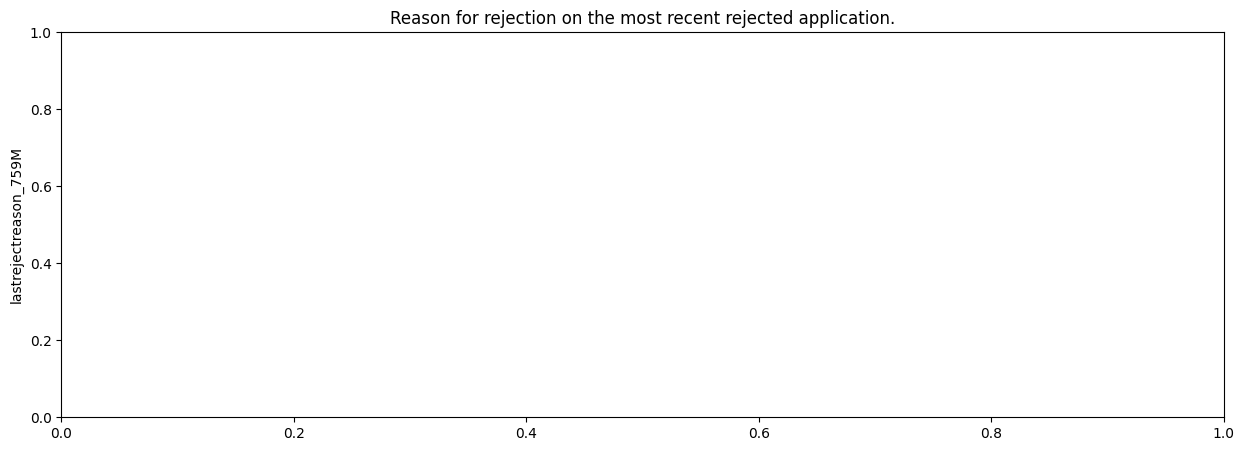

         Х_train   Х_valid    Х_test
count     915995    305332    305332
unique        17        17        18
top     a55475b1  a55475b1  a55475b1
freq      572601    190594    190460


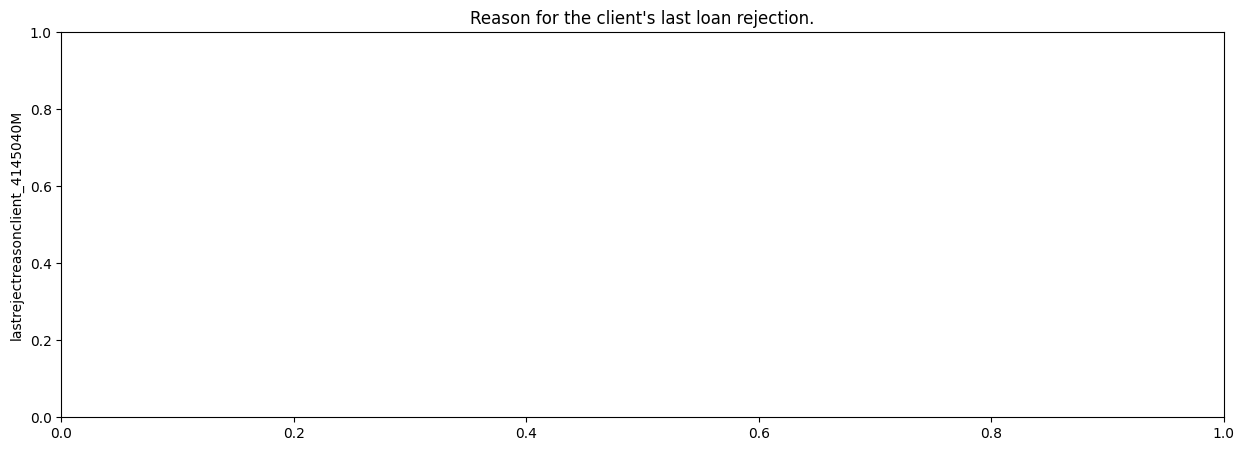

         Х_train   Х_valid    Х_test
count     915995    305332    305332
unique        14        13        11
top     a55475b1  a55475b1  a55475b1
freq      585496    194896    194955


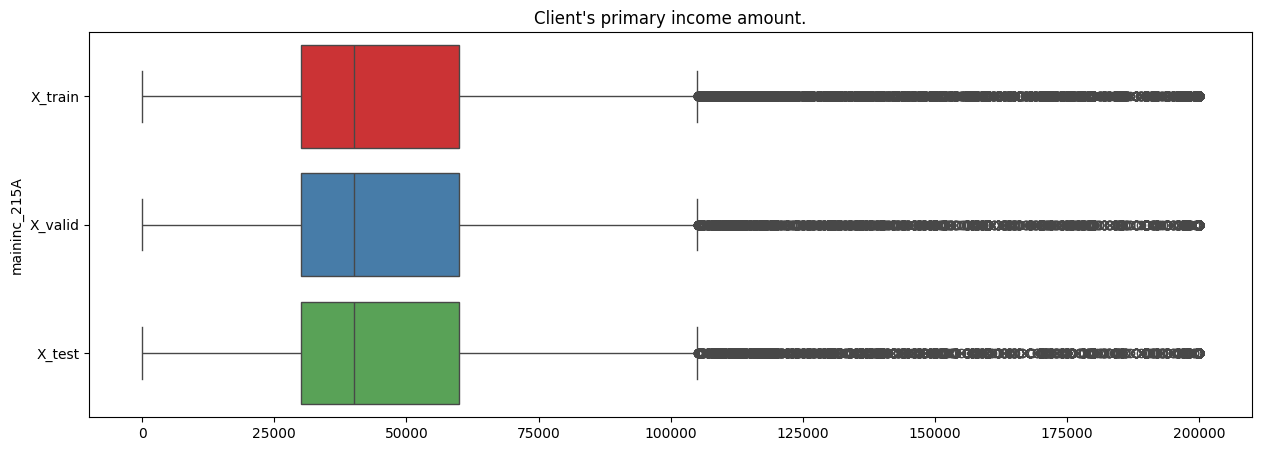

             Х_train        Х_valid         Х_test
count  609459.000000  203070.000000  202875.000000
mean    49472.115176   49552.946154   49458.958881
std     32226.838089   32359.325241   32280.762531
min         0.000000       0.000000       0.000000
25%     30000.000000   30000.000000   30000.000000
50%     40000.000000   40000.000000   40000.000000
75%     60000.000000   60000.000000   60000.000000
max    200000.000000  200000.000000  200000.000000


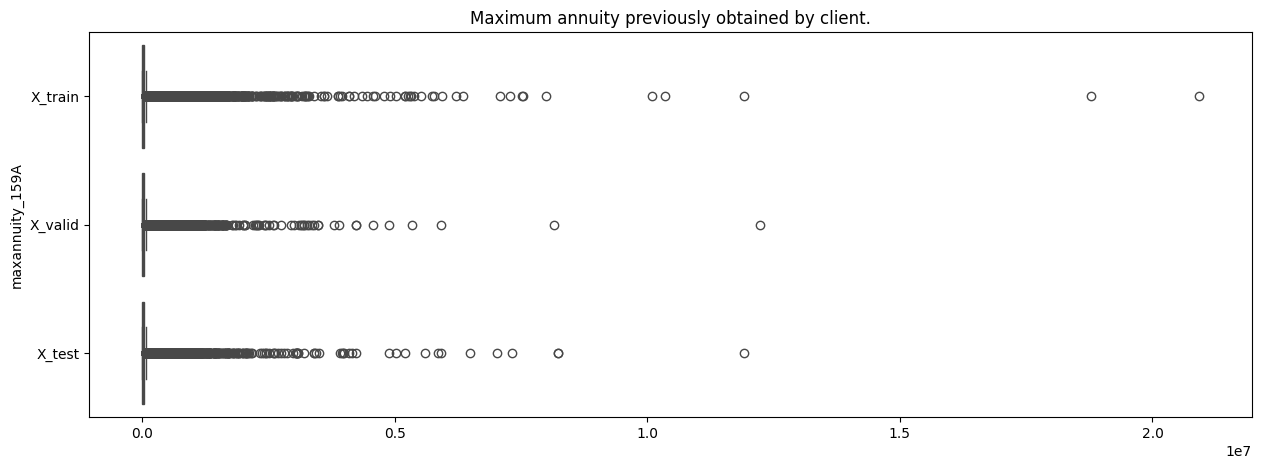

            Х_train       Х_valid        Х_test
count  7.323710e+05  2.440170e+05  2.442520e+05
mean   3.457314e+04  3.450335e+04  3.480993e+04
std    9.610374e+04  8.889642e+04  9.752955e+04
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    4.000000e+03  4.000000e+03  4.000000e+03
50%    1.075962e+04  1.072000e+04  1.078200e+04
75%    3.056803e+04  3.050000e+04  3.080000e+04
max    2.092309e+07  1.222900e+07  1.191907e+07


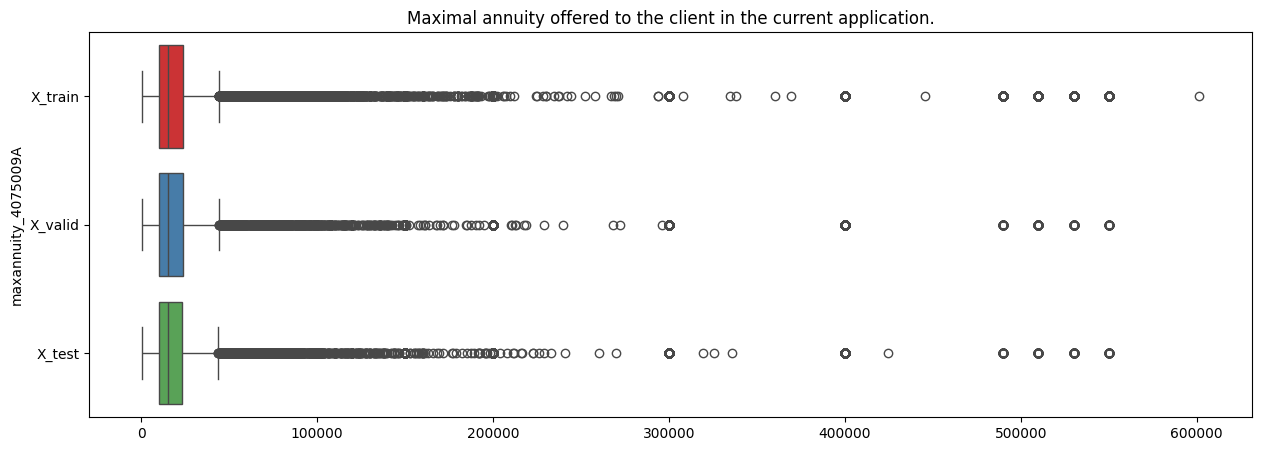

             Х_train        Х_valid         Х_test
count   45573.000000   15087.000000   15273.000000
mean    41682.219516   42289.948963   40472.880246
std     86077.400262   87018.318973   83371.882209
min       600.000000     680.000000     620.000000
25%     10000.000000   10060.000000   10000.000000
50%     15020.000000   15020.000000   15020.000000
75%     23620.000000   23740.000000   23400.000000
max    601320.000000  550000.000000  550000.000000


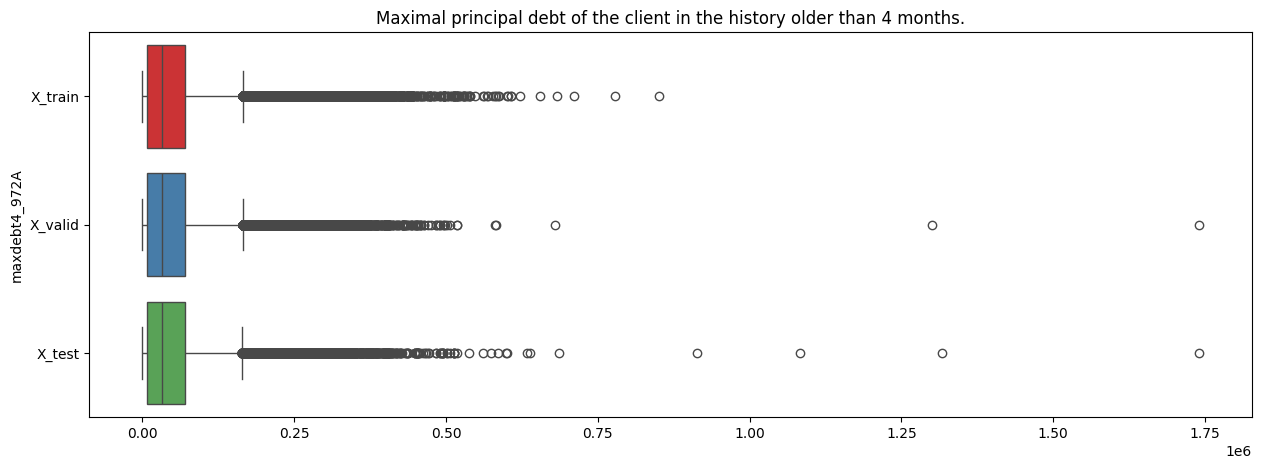

             Х_train       Х_valid        Х_test
count  732371.000000  2.440170e+05  2.442520e+05
mean    48364.871479  4.849439e+04  4.839908e+04
std     53278.649611  5.364926e+04  5.350828e+04
min         0.000000  0.000000e+00  0.000000e+00
25%      7129.400000  7.085600e+03  7.104800e+03
50%     32966.188000  3.291880e+04  3.299600e+04
75%     70324.805000  7.033640e+04  7.019164e+04
max    850201.440000  1.740000e+06  1.740000e+06


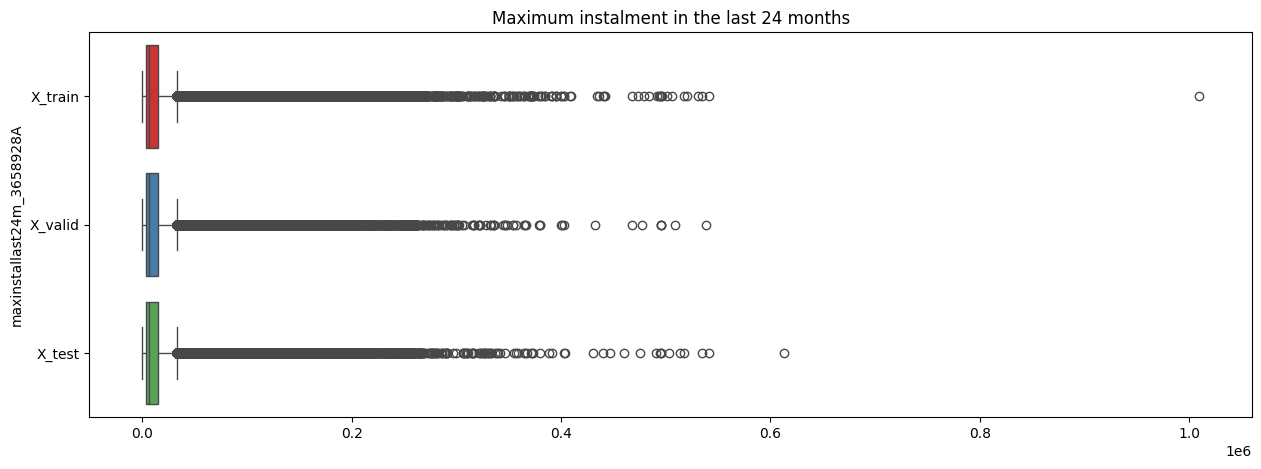

            Х_train        Х_valid         Х_test
count  5.413700e+05  180113.000000  180301.000000
mean   1.534831e+04   15516.439584   15409.427363
std    2.533631e+04   25513.420049   25634.858807
min    0.000000e+00       0.000000       0.200000
25%    3.251800e+03    3271.000000    3264.800000
50%    6.638000e+03    6655.600000    6664.600000
75%    1.514700e+04   15325.601000   15240.601000
max    1.009601e+06  538113.000000  612969.600000


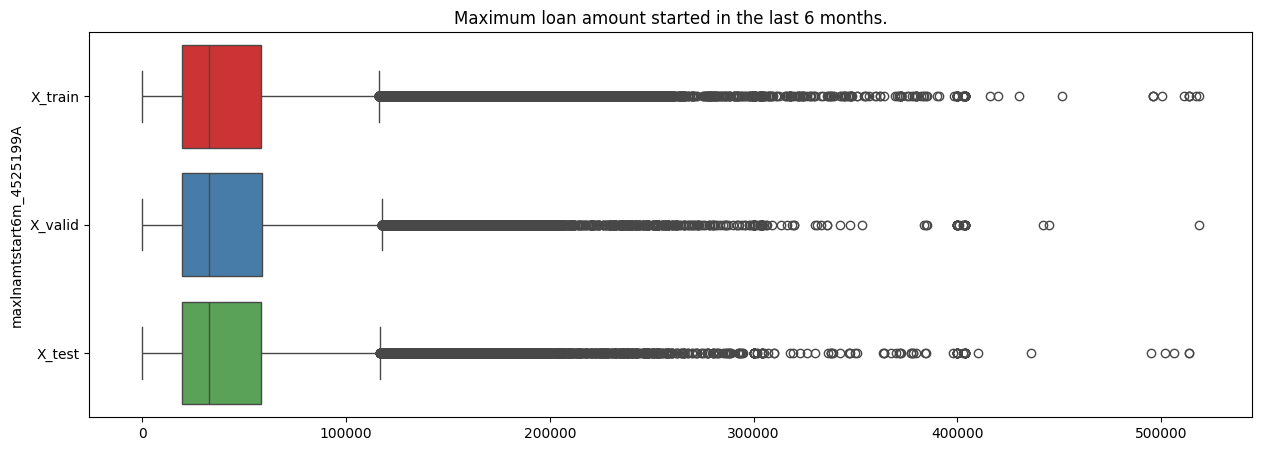

             Х_train        Х_valid         Х_test
count  296657.000000   98344.000000   98802.000000
mean    44853.510373   45029.896520   44953.010842
std     37975.052788   38248.102555   38186.040156
min         0.000000       0.000000       0.000000
25%     19436.600000   19276.000000   19407.050250
50%     32925.402000   32998.000000   32868.300000
75%     58196.000000   58648.800000   58353.700500
max    518629.600000  518629.600000  513520.000000


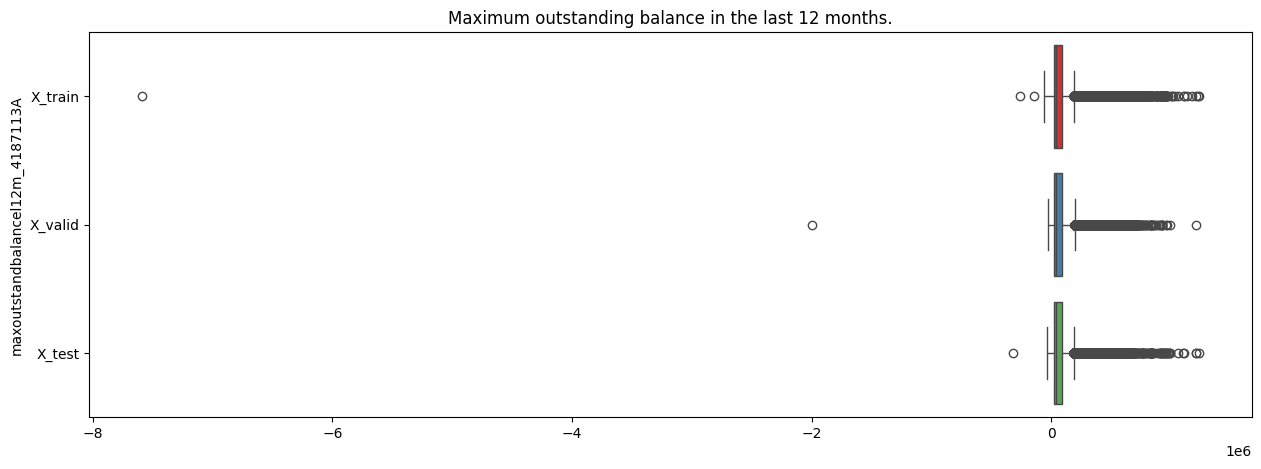

            Х_train       Х_valid        Х_test
count  4.560030e+05  1.516460e+05  1.520520e+05
mean   7.131538e+04  7.154420e+04  7.133005e+04
std    8.205894e+04  8.170095e+04  8.146027e+04
min   -7.588198e+06 -2.000000e+06 -3.200000e+05
25%    2.007380e+04  2.000000e+04  2.011705e+04
50%    4.248449e+04  4.262450e+04  4.254900e+04
75%    9.006510e+04  9.028545e+04  8.972540e+04
max    1.234096e+06  1.212685e+06  1.235313e+06


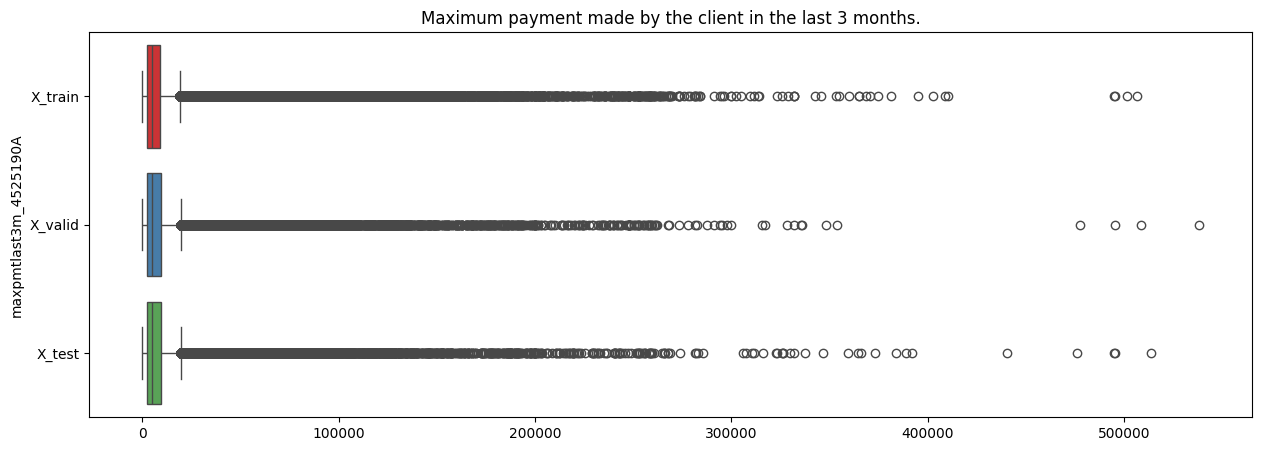

             Х_train        Х_valid         Х_test
count  238607.000000   79095.000000   79627.000000
mean     9906.886979   10128.093158   10006.183837
std     18445.171998   19262.743169   19230.625610
min         0.000000       0.000000       0.000000
25%      2568.200000    2577.100000    2554.800000
50%      4900.000000    4926.000000    4899.000000
75%      9255.900000    9351.800000    9330.698000
max    506425.220000  538113.000000  513520.000000


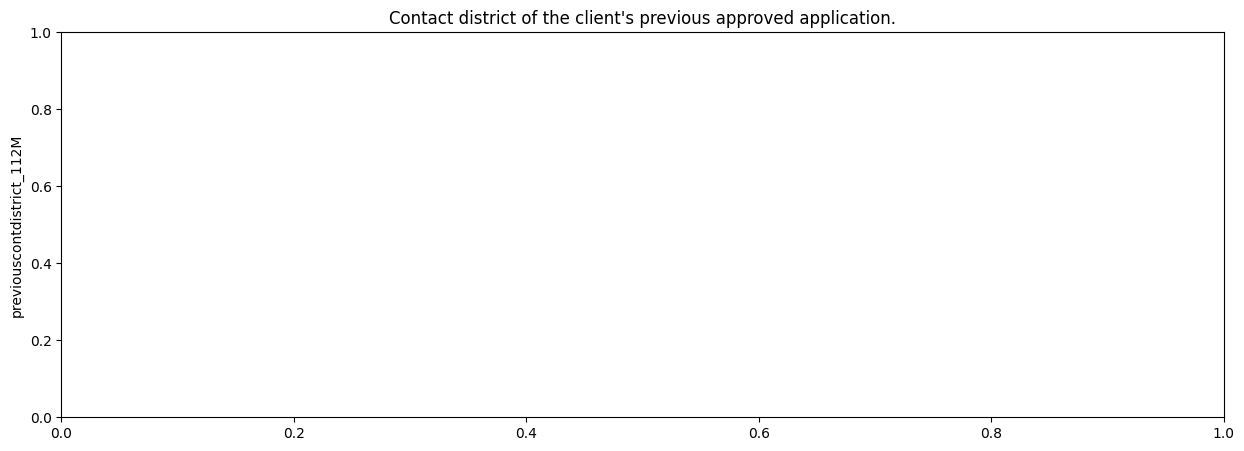

         Х_train   Х_valid    Х_test
count     915995    305332    305332
unique       223       223       223
top     a55475b1  a55475b1  a55475b1
freq      292844     97736     97848


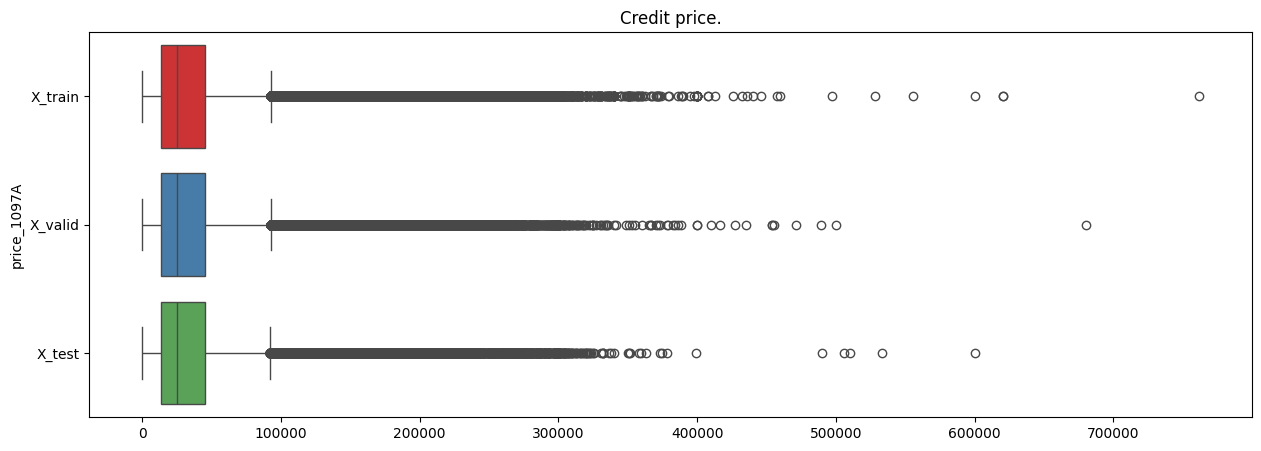

             Х_train        Х_valid         Х_test
count  782191.000000  260615.000000  260613.000000
mean    34459.666967   34528.315509   34417.551758
std     34465.692478   34583.492323   34435.101393
min         0.000000       0.000000       0.000000
25%     13800.000000   13800.000000   13798.000000
50%     25172.000000   25178.000000   25074.000000
75%     45348.902000   45392.000000   45198.000000
max    761867.440000  680000.000000  600000.000000


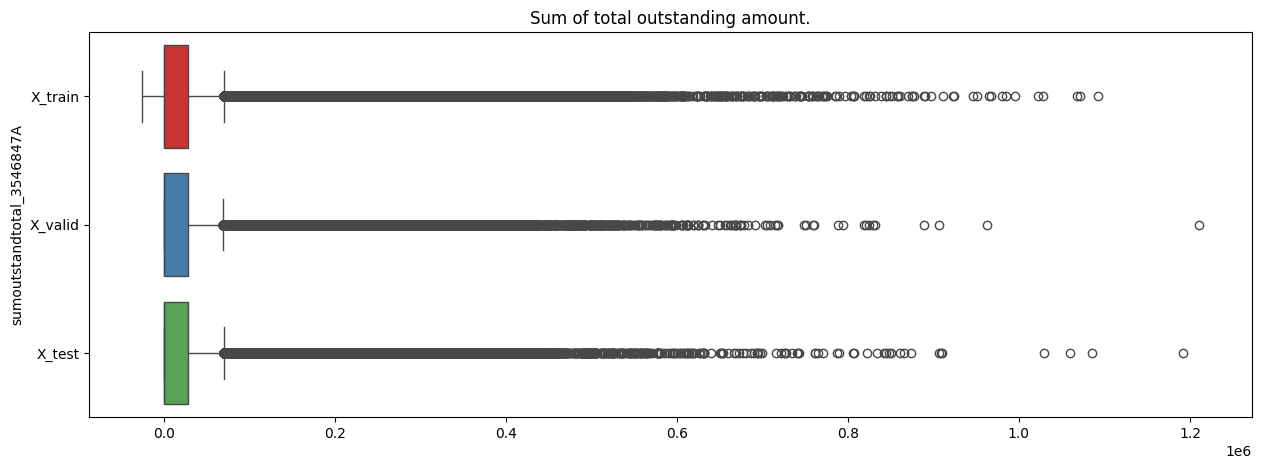

            Х_train       Х_valid        Х_test
count  6.489570e+05  2.162160e+05  2.161660e+05
mean   2.770214e+04  2.760793e+04  2.769194e+04
std    5.839549e+04  5.827701e+04  5.855534e+04
min   -2.504400e+04  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00
75%    2.799800e+04  2.791900e+04  2.800808e+04
max    1.092393e+06  1.210629e+06  1.192101e+06


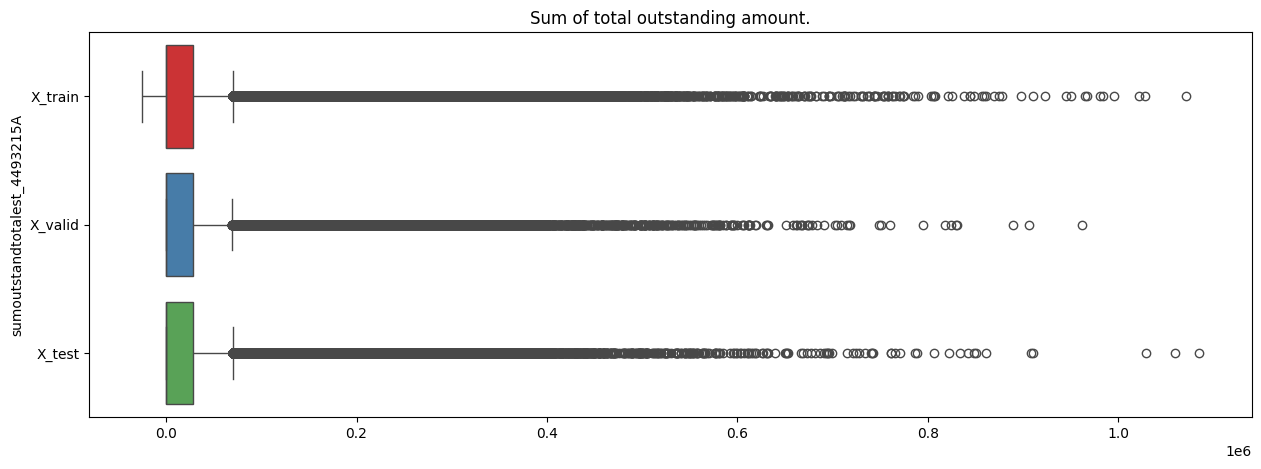

            Х_train        Х_valid        Х_test
count  4.117070e+05  137089.000000  1.372170e+05
mean   2.832341e+04   28189.458742  2.838888e+04
std    6.046442e+04   60262.549445  6.084326e+04
min   -2.504400e+04       0.000000  0.000000e+00
25%    0.000000e+00       0.000000  0.000000e+00
50%    0.000000e+00       0.000000  0.000000e+00
75%    2.799800e+04   27874.201000  2.800000e+04
max    1.071761e+06  962427.600000  1.085048e+06


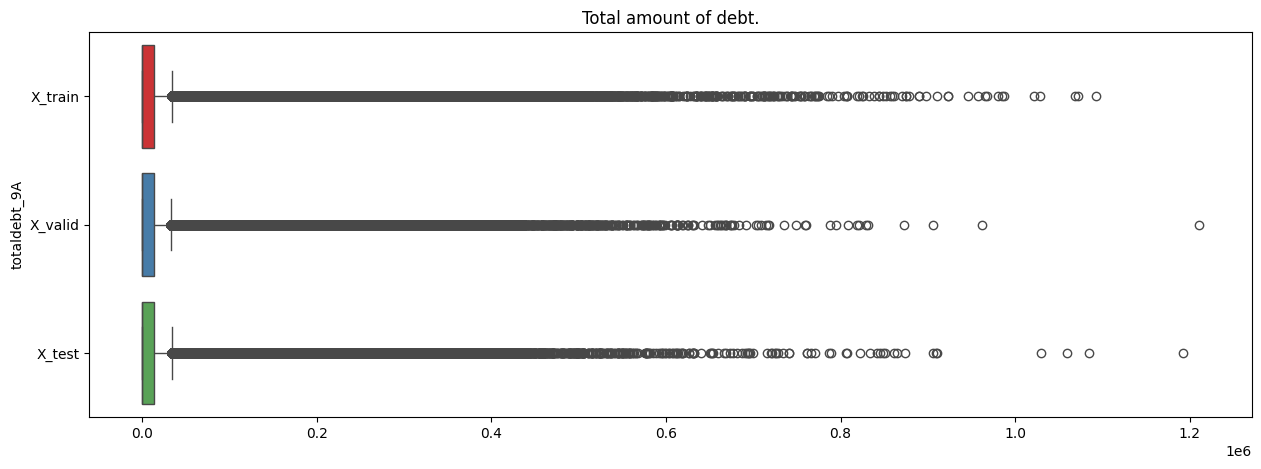

            Х_train       Х_valid        Х_test
count  9.159930e+05  3.053310e+05  3.053320e+05
mean   1.970405e+04  1.963499e+04  1.966845e+04
std    5.083804e+04  5.075828e+04  5.090777e+04
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00
75%    1.355920e+04  1.326740e+04  1.352740e+04
max    1.092393e+06  1.210629e+06  1.192101e+06


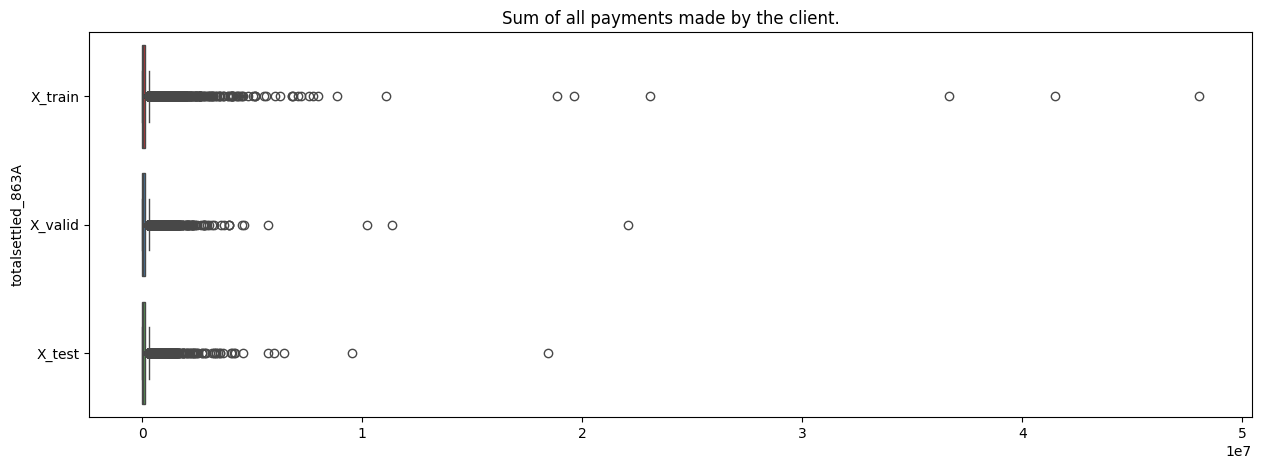

            Х_train       Х_valid        Х_test
count  9.159930e+05  3.053300e+05  3.053320e+05
mean   9.230859e+04  9.204884e+04  9.221623e+04
std    1.695881e+05  1.517096e+05  1.498947e+05
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00
50%    3.598000e+04  3.589171e+04  3.603040e+04
75%    1.189040e+05  1.188702e+05  1.185493e+05
max    4.803504e+07  2.206228e+07  1.842900e+07


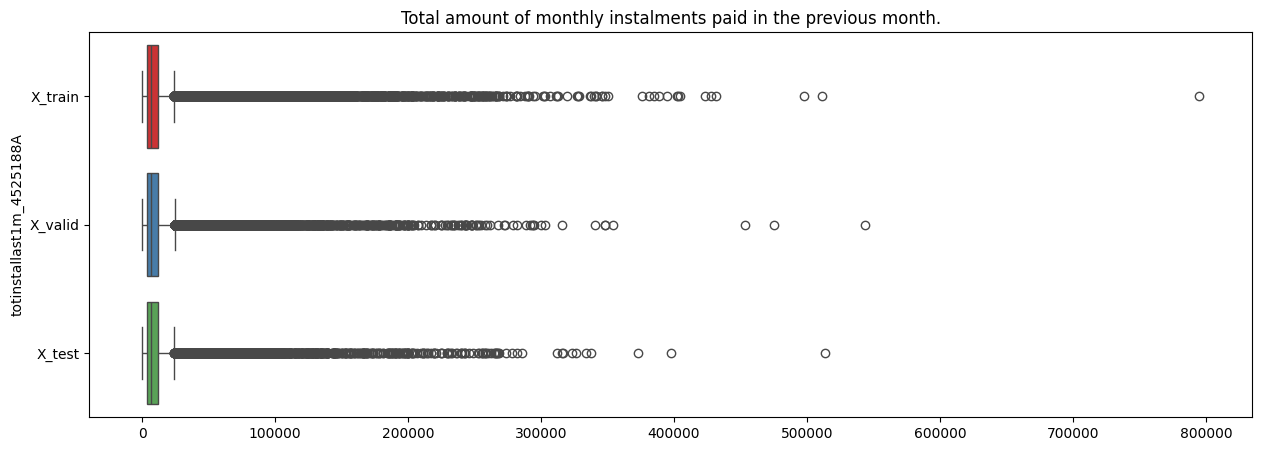

             Х_train        Х_valid         Х_test
count  211726.000000   70161.000000   70561.000000
mean    10365.050559   10564.574288   10398.058541
std     16103.890181   16754.745968   16039.526738
min         0.214000       0.332000       0.222000
25%      3310.887500    3307.000000    3307.800000
50%      6218.100000    6229.200000    6216.400000
75%     11658.000000   11792.800000   11683.400000
max    794899.200000  543734.200000  513520.000000


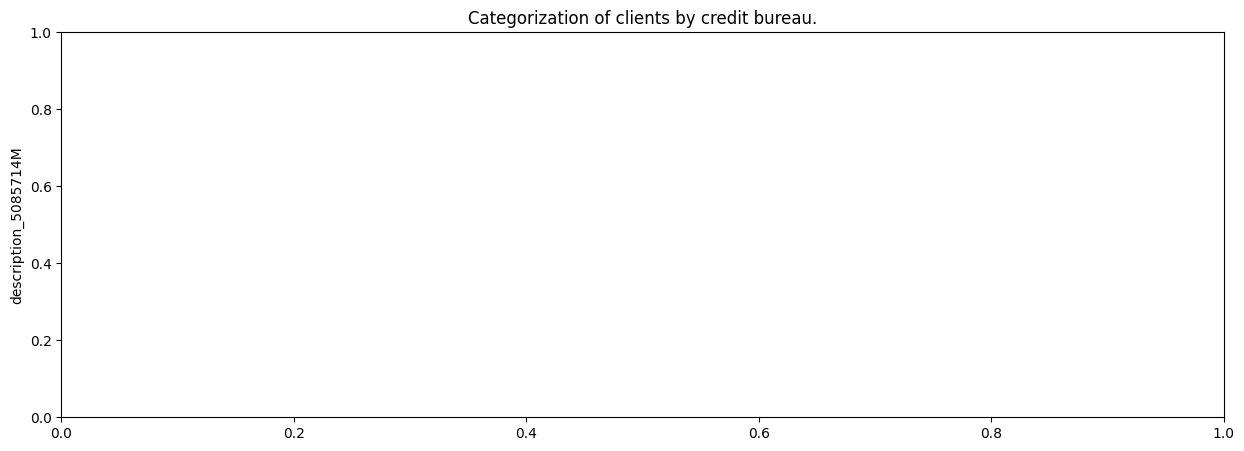

         Х_train   Х_valid    Х_test
count     900228    300183    300065
unique         2         2         2
top     a55475b1  a55475b1  a55475b1
freq      789428    263347    263350


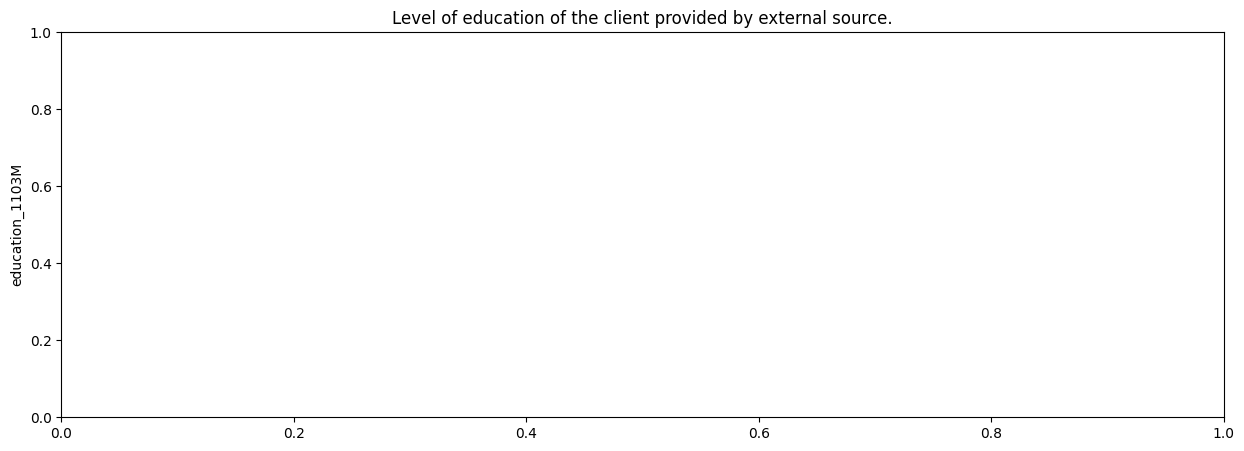

         Х_train   Х_valid    Х_test
count     900228    300183    300065
unique         5         5         5
top     a55475b1  a55475b1  a55475b1
freq      515887    172059    172016


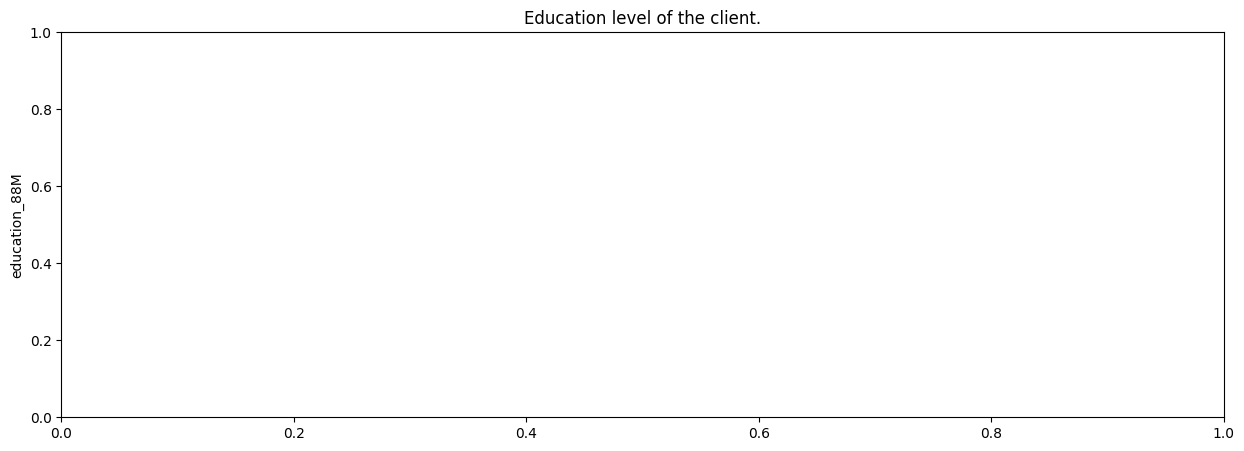

         Х_train   Х_valid    Х_test
count     900228    300183    300065
unique         5         5         5
top     a55475b1  a55475b1  a55475b1
freq      890963    297086    296911


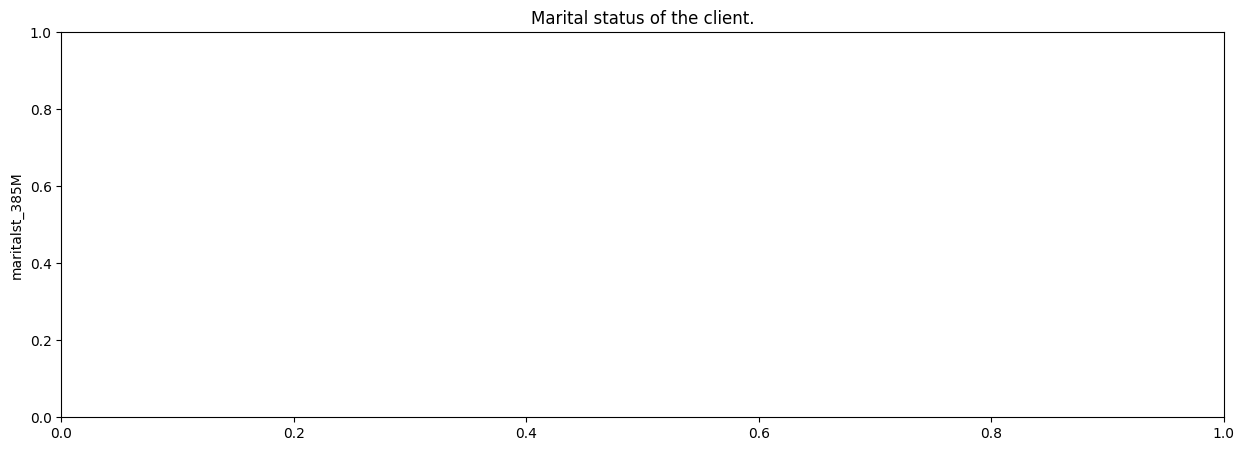

         Х_train   Х_valid    Х_test
count     900228    300183    300065
unique         6         6         6
top     a55475b1  a55475b1  a55475b1
freq      396724    132283    132585


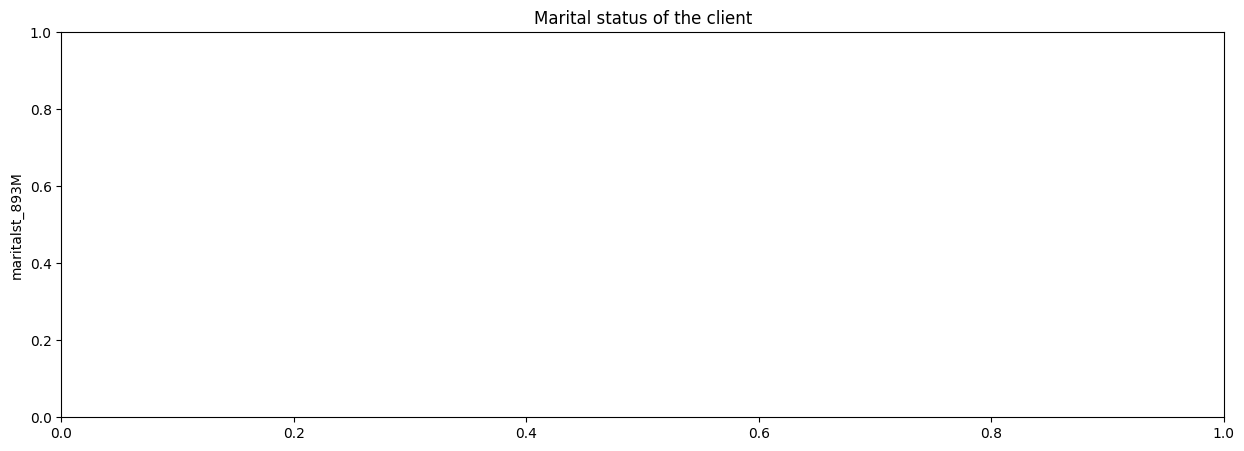

         Х_train   Х_valid    Х_test
count     900228    300183    300065
unique         6         6         6
top     a55475b1  a55475b1  a55475b1
freq      887524    295972    295807


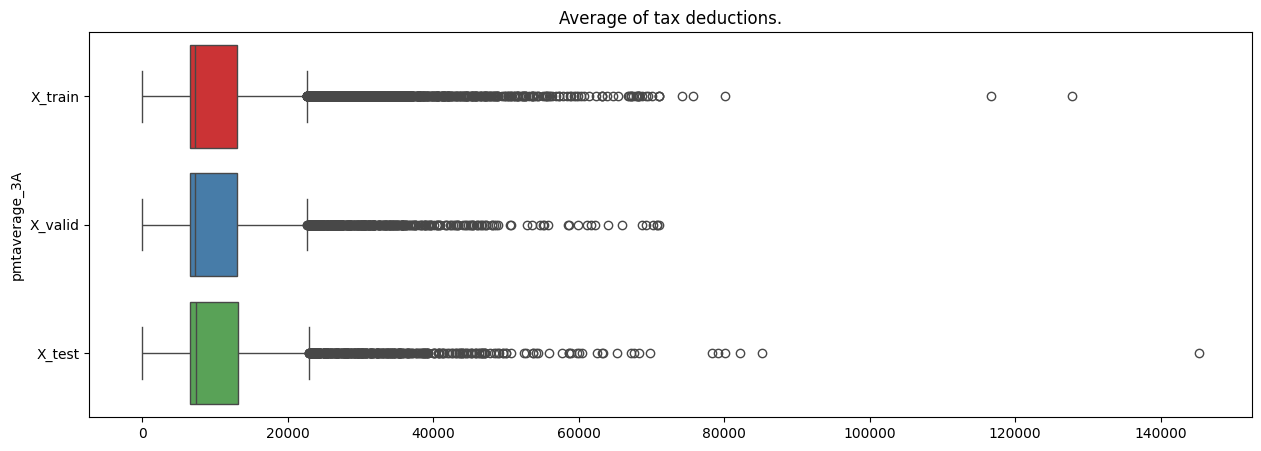

             Х_train       Х_valid         Х_test
count   85889.000000  29081.000000   28619.000000
mean     9292.380057   9302.132933    9336.614230
std      5541.700221   5508.856320    5677.363575
min         0.000000      0.000000       0.000000
25%      6589.800300   6566.300300    6621.900150
50%      7292.500000   7268.833500    7339.500000
75%     13000.601000  13023.900000   13130.400000
max    127760.200000  71089.400000  145257.400000


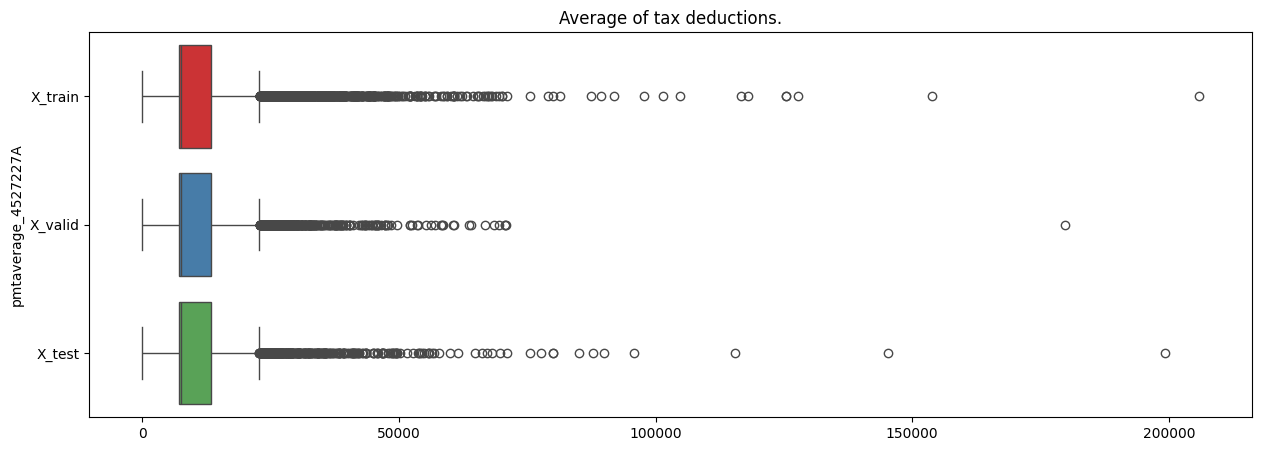

             Х_train        Х_valid         Х_test
count   69005.000000   22953.000000   23020.000000
mean    10040.529823   10030.328852   10015.869416
std      5437.126187    5342.831327    5621.065087
min         4.200000       8.800000      15.200000
25%      7192.200000    7192.400000    7173.550000
50%      7553.000000    7553.000000    7553.000000
75%     13464.400000   13464.400000   13410.800000
max    205848.610000  179814.400000  199301.610000


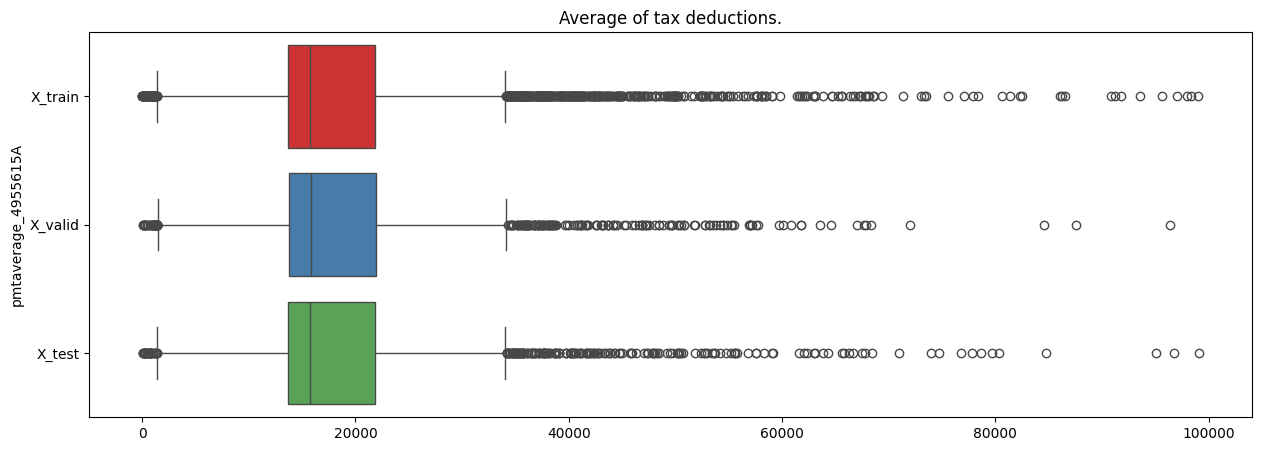

           Х_train       Х_valid        Х_test
count  43210.00000  14201.000000  14434.000000
mean   17648.63806  17673.904656  17639.181797
std     6834.67670   6798.002511   7052.130745
min        4.40000     43.000000     93.200005
25%    13641.60100  13730.400000  13649.400000
50%    15764.00000  15808.200000  15762.400000
75%    21808.85025  21914.201000  21811.150250
max    99012.80500  96337.400000  99085.400000


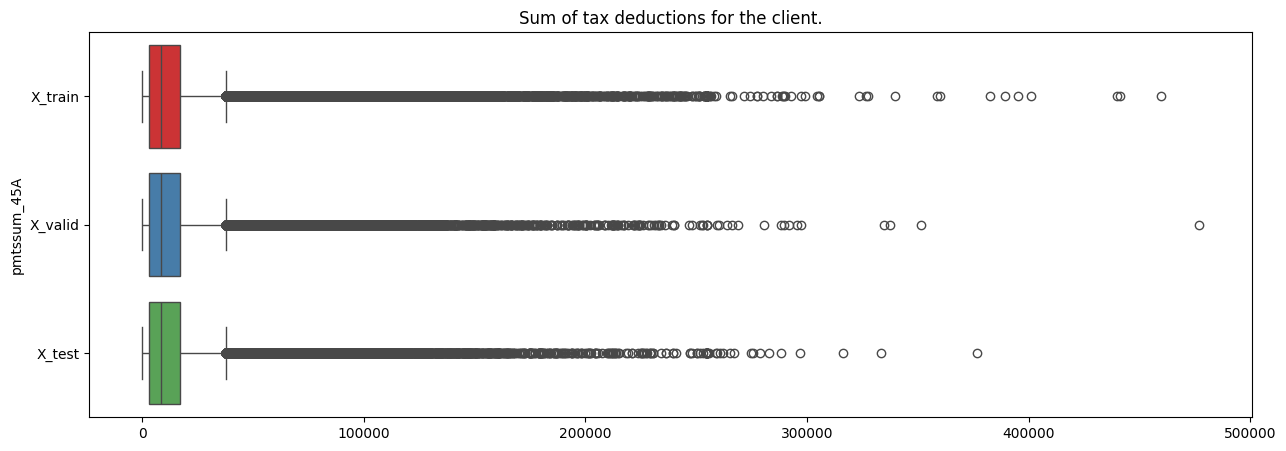

             Х_train        Х_valid         Х_test
count  343810.000000  114529.000000  114299.000000
mean    13165.647983   13274.857795   13228.001230
std     18046.574587   18255.552851   18189.896794
min         0.000000       0.000000       0.000000
25%      3135.850000    3208.400100    3153.526000
50%      8398.026500    8385.400000    8379.704000
75%     16980.967250   17032.201000   16969.910500
max    459898.250000  476843.400000  376819.400000


In [16]:
for col in X_train.columns:
    get_boxplot(col)

## Data optimization

In [17]:
tables = [X_train, X_valid, X_test]

In [52]:
# Number of instalments paid before due date in the last 24 months.
for t in tables:
    t['amtinstpaidbefduel24m_4187115A'].fillna(0, inplace=True)

# indices_to_drop = X_train.index[X_train['amtinstpaidbefduel24m_4187115A'] > 1_100_000]
# X_train = X_train.drop(indices_to_drop)
# y_train = y_train.drop(indices_to_drop)
# base_train = base_train.drop(indices_to_drop)

In [58]:
for t in tables:
    print(t['annuity_780A'].isna().sum())

0
0
0


In [ ]:

# Monthly annuity amount.


# Next month's amount of annuity.
# Average instalments paid by the client over the past 24 months.
# Average loan amount in the last 24 months.
# Average outstanding balance of applicant for the last 6 months.
# Average of payments made by the client in the last 12 months.
# Loan amount or credit card limit.
# Current debt amount of the client.
# Current amount of debt of the applicant.
# Disbursed credit amount after consolidation.
# Amount of downpayment.
# Initial transaction amount of the credit application.
# Commodity category of the last loan applications made by the applicant.
# Commodity type of the last application.
# Credit amount from the client's last application.
# Cancellation reason of the last application.
# Amount of other income reported by the client in their last application.
# Monthly expenses on other loans from the last application.
# Category of commodity in the applicant's last rejected application.
# Commodity type of the last rejected application.
# Credit amount on last rejected application.
# Reason for rejection on the most recent rejected application.
# Reason for the client's last loan rejection.
# Client's primary income amount.
# Maximum annuity previously obtained by client.
# Maximal annuity offered to the client in the current application.
# Maximal principal debt of the client in the history older than 4 months.
# Maximum instalment in the last 24 months
# Maximum loan amount started in the last 6 months.
# Maximum outstanding balance in the last 12 months.
# Maximum payment made by the client in the last 3 months.
# ontact district of the client's previous approved application.
# redit price.
# Sum of total outstanding amount.
# Sum of total outstanding amount.
# Total amount of debt.
# Sum of all payments made by the client.
# Total amount of monthly instalments paid in the previous month.
# Categorization of clients by credit bureau.
# Level of education of the client provided by external source.
# Education level of the client.
# Marital status of the client.
# Marital status of the client
# Average of tax deductions.
# Average of tax deductions.
# Average of tax deductions.
# Sum of tax deductions for the client.

## Training LightGBM

Minimal example of LightGBM training is shown below.

In [41]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/Users/vs/anaconda3/envs/home-credit-2024/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.700986
[100]	valid_0's auc: 0.716929
[150]	valid_0's auc: 0.725493
[200]	valid_0's auc: 0.730316
[250]	valid_0's auc: 0.733407
[300]	valid_0's auc: 0.736535
[350]	valid_0's auc: 0.738156
[400]	valid_0's auc: 0.740132
[450]	valid_0's auc: 0.741469
[500]	valid_0's auc: 0.742637
[550]	valid_0's auc: 0.743961
[600]	valid_0's auc: 0.744919
[650]	valid_0's auc: 0.745632
[700]	valid_0's auc: 0.746185
[750]	valid_0's auc: 0.74708
[800]	valid_0's auc: 0.747765
[850]	valid_0's auc: 0.748229
Early stopping, best iteration is:
[849]	valid_0's auc: 0.748232


Evaluation with AUC and then comparison with the stability metric is shown below.

In [54]:
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    base["score"] = y_pred

print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}') 
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}') 
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')  

The AUC score on the train set is: 0.7671592601560057
The AUC score on the valid set is: 0.748232037783608
The AUC score on the test set is: 0.7509734030134483


In [55]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}')  

The stability score on the train set is: 0.5085436429020449
The stability score on the valid set is: 0.45783914469979997
The stability score on the test set is: 0.4342504575854449


## Submission

Scoring the submission dataset is below, we need to take care of new categories. Then we save the score as a last step. 

In [ ]:
X_submission = data_submission[cols_pred].to_pandas()
X_submission = convert_strings(X_submission)
categorical_cols = X_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    train_categories = set(X_train[col].cat.categories)
    submission_categories = set(X_submission[col].cat.categories)
    new_categories = submission_categories - train_categories
    X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
    new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
    X_train[col] = X_train[col].astype(new_dtype)
    X_submission[col] = X_submission[col].astype(new_dtype)

y_submission_pred = gbm.predict(X_submission, num_iteration=gbm.best_iteration)

In [ ]:
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')
submission.to_csv("./submission.csv")